<a href="https://colab.research.google.com/github/RylieWeaver9/Machine-Learning/blob/main/Vesuvius%20Challenge%20with%20SVM%20Full%20Write-Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vesuvius Challenge w/ SVM**

## - Rylie Weaver



## The following is my extensive write-up of my attempt at the Vesuvius Challenge using an SVM. Since the extensive write-up is extremely long, I have also included a shortened write-up in my submission as a separate pdf.

# 1. Setup

## In this section, I carry out the setup required to work with the data.

## 1.1 System Version, Figure Saving, etc...

### Common imports and setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1.2 Load in Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

# with np.load('/content/gdrive/My Drive/Pomona/Classes/Junior Year/Spring/Machine Learning/Final Project/Data/') as data

DATA_PATH = '/content/gdrive/My Drive/Pomona/Classes/Junior Year/Spring/Machine Learning/Final Project/Data'

Mounted at /content/gdrive


## 1.3 Translating Data from .tif to Usable

### The following class block was written with the help ofBrett Foster, a friend of George

### Classes for loading the data from the Vesuvius challenge. Made to be compatible with tf.keras.utils.Sequence. Written by Brett Foster

### Documentation in comments at the bottom of the code block

In [5]:
import cv2
from tqdm import tqdm


IMAGE_SHAPES = {'1': (8181, 6330), '2': (14830, 9506), '3': (7606, 5249), 'a': (2727, 6330), 'b': (5454, 6330)}
IMAGE_MASK_COUNTS = {'1': 29142840, '2': 97993501, '3': 25065492, 'a': 10818923, 'b': 18323917}


class VesuviusSequence:  # (tf.keras.utils.Sequence):
    def __init__(self, *, images='', input_buffer=1, z_start=0, z_end=65,
                 cached_rows=None, batch_size=1, mask_suffix='', transforms=None):
        self.images = sorted(map(str, set(images)))
        self.buffer = input_buffer
        self.z_range = (z_start, z_end)
        self.cached_rows = cached_rows
        self.batch_size = 1000000000 if batch_size is None else batch_size
        self.mask_suffix = mask_suffix
        self.transforms = [0] if transforms is None else (list(range(8)) if transforms == 'all' else
                                                          ([transforms] if isinstance(transforms, int) else transforms))

        self.files = {image: self.get_files(image) for image in self.images}
        self.segment_counts = {image: self.get_segment_counts(image) for image in self.images}
        self.image_order = [(image, i) for image in self.images for i in range(len(self.segment_counts[image]))]
        self.currently_loaded = None
        self.arr = np.zeros((0,))
        self.order = np.zeros((0,))

    def __len__(self):
        return sum(self.num_batches(c) for counts in self.segment_counts.values() for c in counts)

    def __getitem__(self, idx):
        return NotImplemented

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    def num_batches(self, segment_count):
        return int(np.ceil(segment_count * len(self.transforms) / self.batch_size))

    def load(self, img_idx):
        if self.currently_loaded == img_idx:
            return None
        self.currently_loaded = img_idx
        rows = IMAGE_SHAPES[img_idx[0]][0] if self.cached_rows is None else self.cached_rows
        # Load xray
        self.arr = np.zeros((self.z_range[1]-self.z_range[0], 2*self.buffer+rows,
                             IMAGE_SHAPES[img_idx[0]][1]+2*self.buffer), dtype='float32')
        r1, r2 = img_idx[1]*rows-self.buffer, (img_idx[1]+1)*rows+self.buffer
        offset, r1, r2 = max(0, -r1), max(r1, 0), min(r2, IMAGE_SHAPES[img_idx[0]][0])
        e1, e2 = offset + r2 - r1, self.arr.shape[2] - self.buffer
        for i, file in enumerate(self.files[img_idx[0]][2]):
            self.arr[i, offset:e1, self.buffer:e2] = cv2.imread(file, cv2.IMREAD_ANYDEPTH)[r1:r2]
        self.arr /= 65535.0
        # Load mask
        r1, r2 = img_idx[1]*rows, min((img_idx[1]+1)*rows, IMAGE_SHAPES[img_idx[0]][0])
        mask = np.zeros(self.arr.shape[1:])
        b = self.buffer, self.buffer + r2 - r1, self.buffer, mask.shape[1] - self.buffer
        mask[b[0]:b[1], b[2]:b[3]] = cv2.imread(self.files[img_idx[0]][0], cv2.IMREAD_GRAYSCALE)[r1:r2]
        x, y = np.where(mask > 127)
        transform = np.tile(np.array(self.transforms), len(x)).reshape(1, -1)
        self.order = np.vstack((np.stack((x, y)).repeat(len(self.transforms), axis=1), transform)).T
        return b, r1, r2

    def index_to_order_index(self, idx):
        for img, i in self.image_order:
            n = self.num_batches(self.segment_counts[img][i])
            if idx < n:
                self.load((img, i))
                break
            idx -= n
        return idx * self.batch_size

    def get_image(self, order_idx):
        i, j, transform = self.order[order_idx]
        arr = self.arr[:, i-self.buffer:i+self.buffer+1, j-self.buffer:j+self.buffer+1]
        if transform == 0:
            return arr
        elif transform < 4:
            return np.rot90(arr, transform, (1, 2))
        elif transform == 4:
            return arr.transpose((0, 2, 1))
        else:
            return np.rot90(arr.transpose((0, 2, 1)), transform - 4, (1, 2))

    def get_files(self, image):
        folder = f'{DATA_PATH}/test/{image}' if image in ('a', 'b') else f'{DATA_PATH}/train/{image}'
        mask = f'{folder}/mask{self.mask_suffix}.png'
        labels = f'{folder}/inklabels.png'
        layers = [f'{folder}/surface_volume/{str(i).zfill(2)}.tif' for i in range(*self.z_range)]
        return mask, labels, layers

    def get_segment_counts(self, image):
        mask = cv2.imread(self.files[image][0], cv2.IMREAD_GRAYSCALE)
        rows = len(mask) if self.cached_rows is None else self.cached_rows
        return [(mask[i:i+rows] > 127).sum() for i in range(0, len(mask), rows)]


class VesuviusTrainingSequence(VesuviusSequence):
    def __init__(self, images='123', transforms='all', seed=None, **kwargs):
        VesuviusSequence.__init__(self, images=images, transforms=transforms, **kwargs)
        self.seed = seed
        np.random.default_rng(seed).shuffle(self.image_order)
        self.rng_states = dict()
        self.labels = np.zeros((0,))

    def __getitem__(self, idx):
        order_idx = self.index_to_order_index(idx)
        max_order_idx = min(order_idx + self.batch_size, len(self.order))
        return (np.stack([self.get_image(i) for i in range(order_idx, max_order_idx)]),
                np.stack([self.get_label(i) for i in range(order_idx, max_order_idx)]))

    def get_label(self, order_idx):
        i, j, _ = self.order[order_idx]
        return self.labels[i, j, :]

    def load(self, img_idx):
        res = VesuviusSequence.load(self, img_idx)
        if res is None:
            return None
        b, r1, r2 = res
        self.labels = np.zeros((*self.arr.shape[1:], 1))
        self.labels[b[0]:b[1], b[2]:b[3], 0] = cv2.imread(self.files[img_idx[0]][1], cv2.IMREAD_GRAYSCALE)[r1:r2]
        self.labels /= 255.0
        if self.seed is None:
            rng = np.random.default_rng()
            if img_idx not in self.rng_states:
                self.rng_states[img_idx] = rng.__getstate__()
            else:
                rng.__setstate__(self.rng_states[img_idx])
            rng.shuffle(self.order)
        else:
            seed = (self.seed + img_idx[1] + 10000000 * self.images.index(img_idx[0]))
            np.random.default_rng(seed).shuffle(self.order)
        return res


class VesuviusPredictionSequence(VesuviusSequence):
    def __init__(self, images='ab', **kwargs):
        VesuviusSequence.__init__(self, images=images, mask_suffix='', **kwargs)

    def __getitem__(self, idx):
        order_idx = self.index_to_order_index(idx)
        max_order_idx = min(order_idx + self.batch_size, len(self.order))
        return np.stack([self.get_image(i) for i in range(order_idx, max_order_idx)]),

    def create_image(self, predictions, method='mean', cutoff=0.5):
        predictions = np.concatenate(list(predictions)).reshape((-1, len(self.transforms)))
        if method == 'mean':
            predictions = predictions.mean(axis=1)
        elif method == 'median':
            predictions = np.median(predictions, axis=1)
        predictions = (predictions >= cutoff).astype('uint8') * 255
        output_files = list()
        for image in self.images:
            n = sum(self.segment_counts[image])
            mask = cv2.imread(self.files[image][0], cv2.IMREAD_GRAYSCALE)
            mask[mask > 127] = predictions[:n]
            output_files.append(self.files[image][0].rpartition('/')[0] + '/prediction.png')
            cv2.imwrite(output_files[-1], mask)
            predictions = predictions[n:]
        return output_files


def split_mask(images, split_percents, split_names, ink_perc=None, seed=None):
    split_percents, split_names = zip(*((p, name) for p, name in zip(split_percents, split_names) if name))
    cutoffs, labels = [np.array([0.0, *np.cumsum(split_percents)])], None
    if ink_perc is not None:
        mask_counts = [IMAGE_MASK_COUNTS[image] for image in set(images) if image not in ('a', 'b')]
        n_total, n_ink = sum(x[0] for x in mask_counts), sum(x[1] for x in mask_counts)
        cutoffs.append((ink_perc * n_total / n_ink) * cutoffs[0])
        cutoffs.append(((1 - ink_perc) * n_total / (n_total - n_ink)) * cutoffs[0])
    for i in range(len(cutoffs)):
        if cutoffs[i].sum() > 1.0:
            cutoffs[i] *= (1.0 / cutoffs[i].sum())
    for image in set(images):
        folder = f'{DATA_PATH}/{"test" if str(image) in ("a", "b") else "train"}/{image}'
        mask = cv2.imread(f'{folder}/mask.png', cv2.IMREAD_GRAYSCALE)
        rand = np.random.default_rng(seed).random(mask.shape)
        if ink_perc is not None:
            labels = cv2.imread(f'{folder}/inklabels.png', cv2.IMREAD_GRAYSCALE)
        for i, name in enumerate(split_names):
            if not name:
                continue
            if ink_perc is None or image in 'ab':
                new_mask = ((mask > 127) & (cutoffs[0][i] <= rand) & (rand <= cutoffs[0][i+1])).astype('uint8') * 255
            else:
                new_mask = (labels > 127) & (mask > 127) & (cutoffs[1][i] <= rand) & (rand <= cutoffs[1][i+1])
                new_mask |= (labels <= 127) & (mask > 127) & (cutoffs[2][i] <= rand) & (rand <= cutoffs[2][i+1])
                new_mask = new_mask.astype('uint8') * 255
            cv2.imwrite(f'{folder}/mask{name}.png', new_mask)


# split_mask(...) randomly splits mask.png into multiple parts with the given proportion of data points
# Can be used to create a train/test set, i.e. split_mask('1', [0.8, 0.2], ['train', 'test']) will create two new masks,
# with masktrain.png having 80% of the data points and masktest.png having 20% of the data points. These masks can then
# be used with VesuviusTrainingSequence and VesuviusPredictionSequence to only output that portion of the data
# Arguments:
#   images          - Which images to use e.g. '123', 'ab', '1'
#   split_percents  - List of percentages (0.0 to 1.0) to split the data, e.g. [0.6, 0.3, 0.1]
#                     If they sum to less than one, the remaining data will be discarded
#   split_names     - List of suffixes to append to the filename, i.e. 'test' creates the file masktest.png
#                     Must be the same length as split_percents. Use '' or None in the list to discard that split
#   ink_perc        - The percentage (0.0 to 1.0) of data points that should contain ink.
#                     Defaults to None, which keeps the same proportion as the original images
#   seed            - Random seed to use to split the data, defaults to None

# Arguments for VesuviusTrainingSequence and VesuviusPredictionSequence:
#   images          - Which images to use for data, e.g. '123', 'ab', '1'.
#                     Defaults to '123' for VesuviusTrainingSequence and 'ab' for VesuviusPredictionSequence
#   input_buffer    - Size of the area used to predict the output, e.g. 0 would be a 1x1 area, 1 would be a 3x3 area,
#                     5 would be a 11x11 area, etc. centered on the pixel that's being predicted. Defaults to 1
#   z_start         - Index of the first layer to use (inclusive), can be anything from 0 to 64. Defaults to 0
#   z_end           - Index of the last layer to use (exclusive), can be anything from z_start+1 to 65. Defaults to 65
#                     Using more layers significantly increases loading time and memory usage
#   cached_rows     - How many rows of the xray to store at once. Use None to store the entire xray. Defaults to None
#                     When using a lot of z layers, it can be basically impossible to store everything, so this
#                     significantly decreases memory usage while increasing loading time
#   batch_size      - Upper limit on the number of data points to output at a time. None = no limit. Defaults to 1
#                     Tries to output maximum possible, but will never output data from different caches in one batch
#   mask_suffix     - Which mask to use (mask{mask_suffix}.png), defaults to '' which is the original mask
#                     Meant to be used with split_mask(...) to create train/test data,
#                     where each name in split_names can be used as a mask_suffix here
#   transforms      - Includes transformations (flips/rotations) of the data to increase the number of trianing samples.
#                     0/None = no transformation, 1-3 = rotations, 4-7 = flip + rotations, 'all' = all of the above
#                     Pass a list to specify multiple transformations, e.g. [0, 1, 4].
#                     Defaults to 'all' for VesuviusTrainingSequence and None for VesuviusPredictionSequence
#   seed            - Random seed to shuffle the data, VesuviusTrainingSequence only. Defaults to None

# seq = VesuviusTrainingSequence(...)
# seq[i] outputs a tuple (X_data, y_data),
# where X_data is a numpy array with shape (batch_size, z_end-z_start, 2*buffer+1, 2*buffer+1), and each value in X_data is between 0.0 and 1.0
# and y_data is a numpy array with shape (batch_size, 1), with each value in y_data being either 0.0 for no ink or 1.0 for ink
# Can also iterate over all tuples with "for X_data, y_data in seq:"

# seq = VesuviusPredictionSequence(...)
# seq[i] outputs a tuple (X_data, ) where X_data is the same as in VesuviusTrainingSequence.
# Mainly for test images a and b, which don't have labels
# Will always output in the same order as the original image, unlike VesuviusTrainingSequence which is shuffled
# Also has the function seq.create_image(...) which creates prediction.png for each image showing where the ink
# is predicted to be, and returns a list of the output png files
# VesuviusPredictionSequence.create_image arguments:
#   predictions     - A list/tuple of the prediction batches, e.g. [your_model.predict(batch) for batch, in seq]
#   method          - 'mean' or 'median', defaults to 'mean'. Only matters if using more than one transformation, where
#                     it congregates the guesses from each transformation into a single prediction
#   cutoff          - The cutoff prediction value (after applying method) for whether or not a pixel has ink. Defaults to 0.5


### The following code is where the data is where we choose the pipeline of how the data is loaded in. Specifically, for each point of concern, a 7x7x5 box of grayscale values are retrieved to be the inputs by which we train on. The box's xy values are centered on the point of concern, and the z goes from layer 10 to layer 15.

In [6]:
# Parameters
images = '123'
total_samples, train_split, test_split = 5000, 0.8, 0.2  # Approximately 5000 samples, 80% of which are training and 20% are testing
buffer, z_start, z_end = 3, 10, 15  # 2*buffer+1 = 7, z_end-z_start = 5 -> input shape is 7x7x5
cached_rows, batch_size = 1000, 128  # Increasing cached_rows and/or batch_size increases memory usage and decreases load time, but should have no effect on the data itself

def load_xy_data(mask):
    seq = VesuviusTrainingSequence(images=images, input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=cached_rows, batch_size=batch_size, mask_suffix=mask, transforms=None, seed=42)
    batches = [batch for batch in tqdm(seq, total=len(seq), desc=f'Loading {mask} data')]
    X_data, y_data = np.concatenate([x for x, y in batches]), np.concatenate([y for x, y in batches])
    return X_data.reshape(len(X_data), -1), y_data.flatten()

# Split into train/test
percent_data_used = total_samples / sum(IMAGE_MASK_COUNTS[image] for image in images)
split_mask(images, [train_split*percent_data_used, test_split*percent_data_used], ['train', 'test'], seed=42)

# Load data
X_train, y_train = load_xy_data('train')
X_test, y_test = load_xy_data('test')

print('\nTrain data shape:', X_train.shape, y_train.shape)
print('\nTest data shape:', X_test.shape, y_test.shape)

Loading test data: 100%|██████████| 32/32 [04:46<00:00,  8.96s/it]


Train data shape: (4039, 245) (4039,)

Test data shape: (994, 245) (994,)


## 1.4 Ink Prediction Visual

### This is how we produce out the prediction picture for the training scroll (done last)

In [ ]:
# Function to predict the ink for a whole image
def show_prediction(image, model, prediction_cached_rows=500, prediction_batch_size=32):
    seq = VesuviusPredictionSequence(images=str(image), input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=prediction_cached_rows, batch_size=prediction_batch_size)
    predictions = [model.predict(X_data.reshape(len(X_data), -1)) for X_data, in tqdm(seq, total=len(seq), desc=f'Predicting image {image}')]
    output_file = seq.create_image(predictions)[0]
    im = cv2.imread(output_file, cv2.IMREAD_GRAYSCALE)
    plt.imshow(im, cmap='gray')

## 1.5 Imports

### Making imports to carry out SVM models and analysis of those models

In [8]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier

In [9]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.spatial.distance import cdist

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## 1.6 Balance Data w/ Adasyn Algorithm

### The data was very imbalanced at first, with the large majority of the points being black. Because of this, models were just predicting every poit to not have ink and coming back with ~83% accuracy (not very useful). I used ADASYN to ameliorate this.

In [12]:
from collections import Counter
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN

# Print the class distribution before resampling
print("Before resampling:", Counter(y_train))

# Resample the training set using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Print the class distribution after resampling
print("After resampling:", Counter(y_train_resampled))

Before resampling: Counter({0.0: 3379, 1.0: 660})
After resampling: Counter({1.0: 3384, 0.0: 3379})


# **SVM**

## Summary of SVM:

### I used linear, polynomial, gaussian, and sigmoid kernels with various hyperparameters and also combined the best models into a voting classifier. I then tried the previous models after transforming the input data with a nonlinear function. I also tried using a different data input pipeline. Nothing worked well. In fact, some methods were even somewhat significantly worse than a coin flip, which resulted in an odd scenario where the best classifiers were (1) The voting classifier (2) The exact opposite prediction of a polynomial kernel classifier.

### It's possible that there is some combination of methods that would make an SVM model which is effective for the Vesuvius Challenge, but I'm not confident in it. I conclude that an SVM is not an effective model to analyze this problem, which corroborates with the facts that (1) No example submission for the Vesuvius Challenge that we know of use an SVM and (2) The Vesuvius Challenge has a large cash prize, so I'd expect only complex models to do well on it.

## General Notes:


### **1.**   I don't find the area under my ROC curves because (1) No model works well enough to justify using and (2) The models usually go under the curve at some points, which seems to give very odd values for the area under the curve calculation.
### **2.**   I didn't use gridsearch or cross-validation because of computation time. Because the data was large, fitting multiple models with different hyperparameters risked too much time and me losing half the models that were fitted. Because of this, I checked one hyperparameter combination at a time. I also didn't play with a lot of hyperparameter combinations because the models with those combinations took too long to train.
### **3.**  I believe that the reason some models had ROC curves under the coin-flip is because of the ADASYN balancing of the dataset. Since SVM doesn't fit the data well, it becomes slightly better than a coin flip on the ADASYN balanced training data. But then, when evaluated on the unbalanced testing data, it's making just as many mistaked on the overrepresented dataset, but fewer successes on the underrepresented dataset.
### **4.** I didn't rigorously check for overfitting, but I did show the ROC curves on training data a few times. I conclude from those ROC curves that my models were overfit, even at low hyperparameters. There is the possibility that too many parameters are included in the data processing pipeline step above (the shape surrounding a point of interest for parameters), which could make all of my models overfit, but I'm not aware of a way to rigorously check this without immense computation. The oddities of my model seemingly being overfit even at low hyperparameters lends me to believe more that SVM is not suited for this problem.

# 2. Kernels w/ Probability

## Here, I play with various kernels while using the probability hyperparameter. Using the probability parameter allowed me to see the confusion matrix at various thresholds and to plot the ROC curve, but it also slowed down computation time.

## 2.1 Linear Kernel

### I didn't play with coef0 or higher C because of computation time.

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  2 824]
 [  3 165]]
Threshold: 0.25
Confusion matrix:
[[  9 817]
 [  6 162]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 22 804]
 [  7 161]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 46 780]
 [ 13 155]]
Threshold: 0.4
Confusion matrix:
[[106 720]
 [ 25 143]]
Threshold: 0.45
Confusion matrix:
[[249 577]
 [ 56 112]]
Threshold: 0.5
Confusion matrix:
[[439 387]
 [ 95  73]]
Threshold: 0.55
Confusion matrix:
[[637 189]
 [137  31]]
Threshold: 0.6000000000000001
Confusion matrix:
[[741  85]
 [154  14]]
Threshold: 0.65
Confusion matrix:
[[787  39]
 [159   9]]
Threshold: 0.7000000000000001
Confusion matrix:
[[810  16]
 [162   6]]
Threshold: 0.75
Confusion matrix:
[[822   4]
 [165   3]]
Threshold: 0.8
Confu

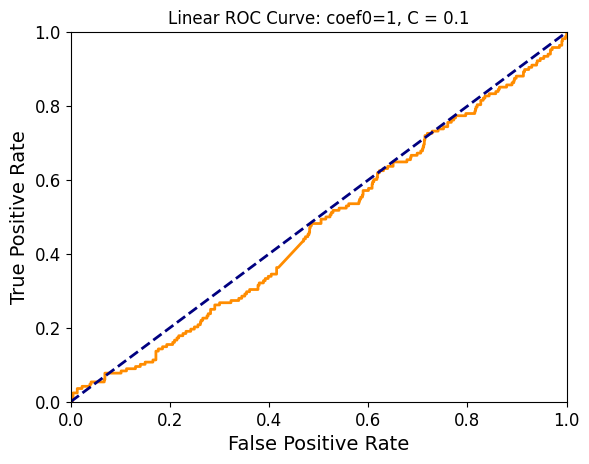

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

Training Data ROC Curve:

Threshold: 0.0
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.05
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.1
Confusion matrix:
[[   4 3375]
 [   0 3384]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  14 3365]
 [   0 3384]]
Threshold: 0.2
Confusion matrix:
[[  30 3349]
 [   2 3382]]
Threshold: 0.25
Confusion matrix:
[[  59 3320]
 [   8 3376]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 135 3244]
 [  19 3365]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 303 3076]
 [  41 3343]]
Threshold: 0.4
Confusion matrix:
[[ 773 2606]
 [ 124 3260]]
Threshold: 0.45
Confusion matrix:
[[1355 2024]
 [ 409 2975]]
Threshold: 0.5
Confusion matrix:
[[2105 1274]
 [1069 2315]]
Threshold: 0.55
Confusion matrix:
[[2733  646]
 [2108 1276]]
Threshold: 0.6000000000000001
Confusion matrix:
[[3073  306]
 [2786  598]]
Threshold: 0.65
Confusion matrix:
[[3239  140]
 [3209  175]]
Threshold: 0.7000000000000001
Confusion matrix:
[[3322   57]
 [3308   76]]
Threshold: 0.75
C

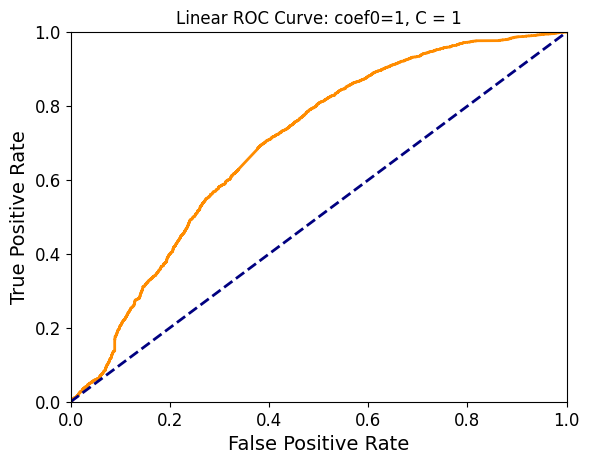

In [15]:
c_param = 1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(X_train_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_train_resampled, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  3 823]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  7 819]
 [  4 164]]
Threshold: 0.25
Confusion matrix:
[[ 13 813]
 [  5 163]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 36 790]
 [  8 160]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 66 760]
 [ 14 154]]
Threshold: 0.4
Confusion matrix:
[[149 677]
 [ 33 135]]
Threshold: 0.45
Confusion matrix:
[[286 540]
 [ 62 106]]
Threshold: 0.5
Confusion matrix:
[[458 368]
 [ 98  70]]
Threshold: 0.55
Confusion matrix:
[[640 186]
 [136  32]]
Threshold: 0.6000000000000001
Confusion matrix:
[[725 101]
 [154  14]]
Threshold: 0.65
Confusion matrix:
[[782  44]
 [159   9]]
Threshold: 0.7000000000000001
Confusion matrix:
[[802  24]
 [162   6]]
Threshold: 0.75
Confusion matrix:
[[814  12]
 [164   4]]
Threshold: 0.8
Confu

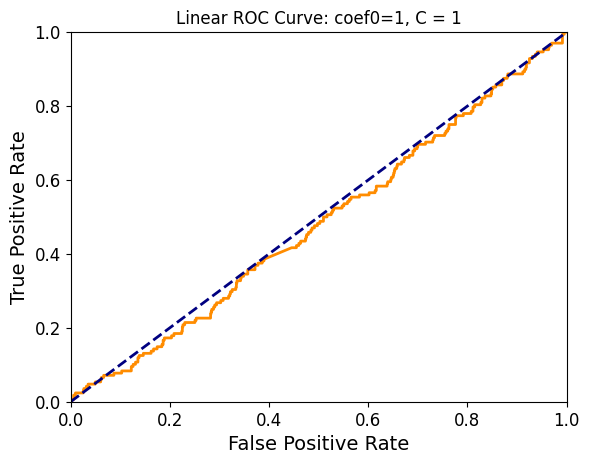

In [ ]:
c_param = 1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  3 823]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  8 818]
 [  2 166]]
Threshold: 0.25
Confusion matrix:
[[ 18 808]
 [  5 163]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 33 793]
 [  7 161]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 71 755]
 [ 14 154]]
Threshold: 0.4
Confusion matrix:
[[144 682]
 [ 27 141]]
Threshold: 0.45
Confusion matrix:
[[293 533]
 [ 55 113]]
Threshold: 0.5
Confusion matrix:
[[469 357]
 [101  67]]
Threshold: 0.55
Confusion matrix:
[[655 171]
 [132  36]]
Threshold: 0.6000000000000001
Confusion matrix:
[[723 103]
 [151  17]]
Threshold: 0.65
Confusion matrix:
[[785  41]
 [158  10]]
Threshold: 0.7000000000000001
Confusion matrix:
[[803  23]
 [162   6]]
Threshold: 0.75
Confusion matrix:
[[812  14]
 [164   4]]
Threshold: 0.8
Confu

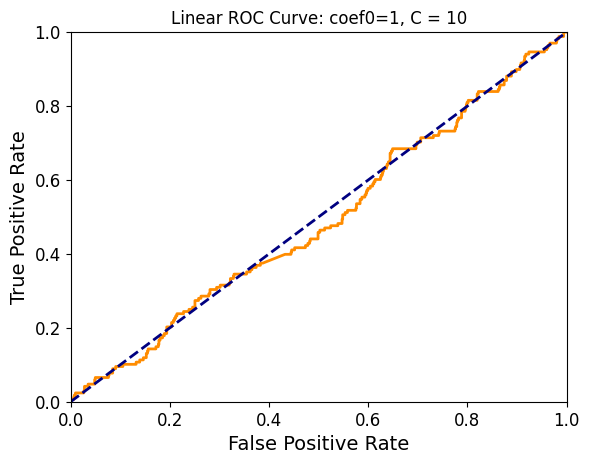

In [ ]:
c_param = 10

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

## 2.2 Polynomial Kernel

### Most of the polynomial kernels are significantly below the coin-flip curve. However, as the degree of the kernel and C goes up, the model gets less bad (more towards the coin-flip).

### I didn't play with higher C becasue of computation time.

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  2 824]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  4 822]
 [  1 167]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  6 820]
 [  1 167]]
Threshold: 0.2
Confusion matrix:
[[ 12 814]
 [  4 164]]
Threshold: 0.25
Confusion matrix:
[[ 24 802]
 [  8 160]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 40 786]
 [ 14 154]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 65 761]
 [ 22 146]]
Threshold: 0.4
Confusion matrix:
[[108 718]
 [ 30 138]]
Threshold: 0.45
Confusion matrix:
[[210 616]
 [ 53 115]]
Threshold: 0.5
Confusion matrix:
[[359 467]
 [ 91  77]]
Threshold: 0.55
Confusion matrix:
[[657 169]
 [142  26]]
Threshold: 0.6000000000000001
Confusion matrix:
[[791  35]
 [164   4]]
Threshold: 0.65
Confusion matrix:
[[819   7]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.8
Confu

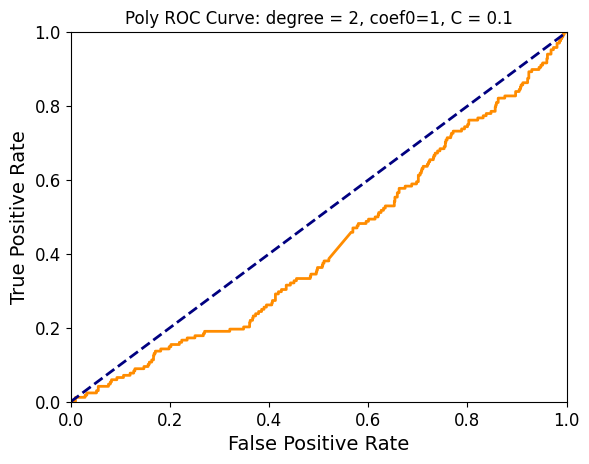

In [ ]:
c_param = 0.1
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 13 813]
 [  6 162]]
Threshold: 0.1
Confusion matrix:
[[ 30 796]
 [ 12 156]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 41 785]
 [ 14 154]]
Threshold: 0.2
Confusion matrix:
[[ 66 760]
 [ 15 153]]
Threshold: 0.25
Confusion matrix:
[[ 99 727]
 [ 23 145]]
Threshold: 0.30000000000000004
Confusion matrix:
[[140 686]
 [ 32 136]]
Threshold: 0.35000000000000003
Confusion matrix:
[[197 629]
 [ 42 126]]
Threshold: 0.4
Confusion matrix:
[[256 570]
 [ 66 102]]
Threshold: 0.45
Confusion matrix:
[[335 491]
 [ 86  82]]
Threshold: 0.5
Confusion matrix:
[[410 416]
 [105  63]]
Threshold: 0.55
Confusion matrix:
[[552 274]
 [135  33]]
Threshold: 0.6000000000000001
Confusion matrix:
[[707 119]
 [152  16]]
Threshold: 0.65
Confusion matrix:
[[769  57]
 [161   7]]
Threshold: 0.7000000000000001
Confusion matrix:
[[808  18]
 [166   2]]
Threshold: 0.75
Confusion matrix:
[[819   7]
 [167   1]]
Threshold: 0.8
Confu

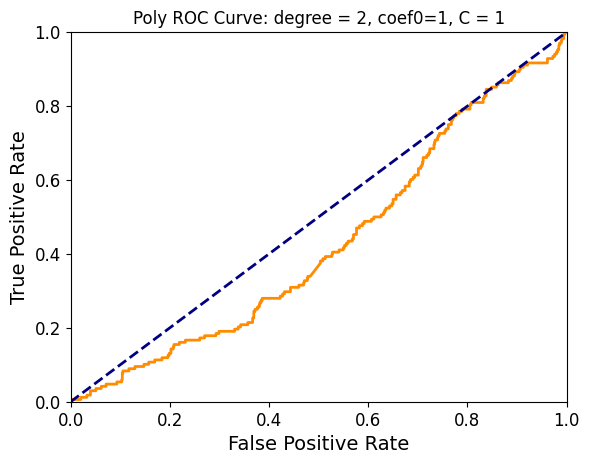

In [ ]:
c_param = 1
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 66 760]
 [ 12 156]]
Threshold: 0.1
Confusion matrix:
[[109 717]
 [ 24 144]]
Threshold: 0.15000000000000002
Confusion matrix:
[[152 674]
 [ 32 136]]
Threshold: 0.2
Confusion matrix:
[[189 637]
 [ 42 126]]
Threshold: 0.25
Confusion matrix:
[[233 593]
 [ 53 115]]
Threshold: 0.30000000000000004
Confusion matrix:
[[275 551]
 [ 63 105]]
Threshold: 0.35000000000000003
Confusion matrix:
[[320 506]
 [ 81  87]]
Threshold: 0.4
Confusion matrix:
[[367 459]
 [ 91  77]]
Threshold: 0.45
Confusion matrix:
[[425 401]
 [104  64]]
Threshold: 0.5
Confusion matrix:
[[479 347]
 [116  52]]
Threshold: 0.55
Confusion matrix:
[[553 273]
 [128  40]]
Threshold: 0.6000000000000001
Confusion matrix:
[[637 189]
 [145  23]]
Threshold: 0.65
Confusion matrix:
[[710 116]
 [151  17]]
Threshold: 0.7000000000000001
Confusion matrix:
[[758  68]
 [158  10]]
Threshold: 0.75
Confusion matrix:
[[788  38]
 [159   9]]
Threshold: 0.8
Confu

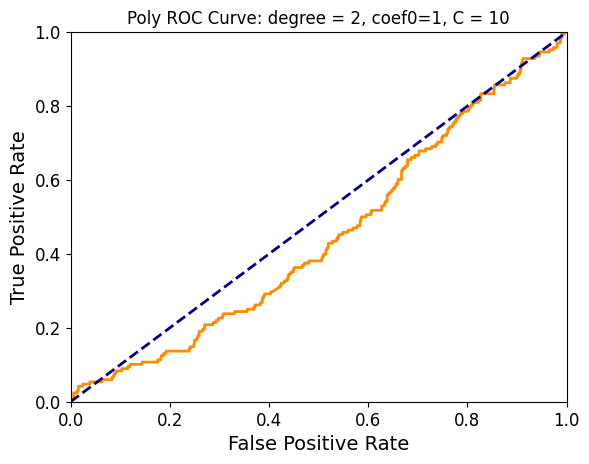

In [ ]:
c_param = 10
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[134 692]
 [ 29 139]]
Threshold: 0.1
Confusion matrix:
[[193 633]
 [ 42 126]]
Threshold: 0.15000000000000002
Confusion matrix:
[[244 582]
 [ 56 112]]
Threshold: 0.2
Confusion matrix:
[[300 526]
 [ 61 107]]
Threshold: 0.25
Confusion matrix:
[[343 483]
 [ 74  94]]
Threshold: 0.30000000000000004
Confusion matrix:
[[380 446]
 [ 87  81]]
Threshold: 0.35000000000000003
Confusion matrix:
[[415 411]
 [ 94  74]]
Threshold: 0.4
Confusion matrix:
[[463 363]
 [108  60]]
Threshold: 0.45
Confusion matrix:
[[509 317]
 [115  53]]
Threshold: 0.5
Confusion matrix:
[[564 262]
 [130  38]]
Threshold: 0.55
Confusion matrix:
[[616 210]
 [137  31]]
Threshold: 0.6000000000000001
Confusion matrix:
[[663 163]
 [145  23]]
Threshold: 0.65
Confusion matrix:
[[707 119]
 [150  18]]
Threshold: 0.7000000000000001
Confusion matrix:
[[743  83]
 [154  14]]
Threshold: 0.75
Confusion matrix:
[[768  58]
 [156  12]]
Threshold: 0.8
Confu

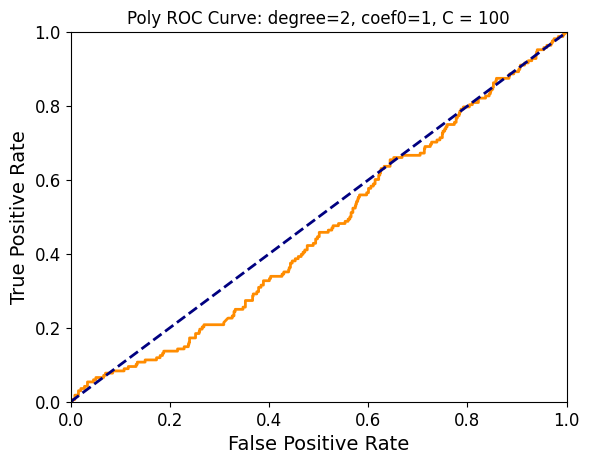

In [ ]:
c_param = 100
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 12 814]
 [  5 163]]
Threshold: 0.1
Confusion matrix:
[[ 31 795]
 [  7 161]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 43 783]
 [ 12 156]]
Threshold: 0.2
Confusion matrix:
[[ 64 762]
 [ 16 152]]
Threshold: 0.25
Confusion matrix:
[[ 91 735]
 [ 23 145]]
Threshold: 0.30000000000000004
Confusion matrix:
[[133 693]
 [ 34 134]]
Threshold: 0.35000000000000003
Confusion matrix:
[[178 648]
 [ 49 119]]
Threshold: 0.4
Confusion matrix:
[[235 591]
 [ 63 105]]
Threshold: 0.45
Confusion matrix:
[[327 499]
 [ 86  82]]
Threshold: 0.5
Confusion matrix:
[[425 401]
 [108  60]]
Threshold: 0.55
Confusion matrix:
[[561 265]
 [132  36]]
Threshold: 0.6000000000000001
Confusion matrix:
[[709 117]
 [156  12]]
Threshold: 0.65
Confusion matrix:
[[773  53]
 [164   4]]
Threshold: 0.7000000000000001
Confusion matrix:
[[805  21]
 [166   2]]
Threshold: 0.75
Confusion matrix:
[[815  11]
 [166   2]]
Threshold: 0.8
Confu

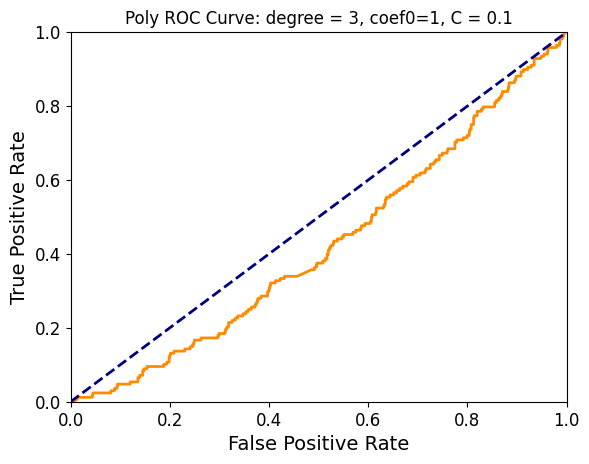

In [ ]:
c_param = 0.1
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 78 748]
 [ 11 157]]
Threshold: 0.1
Confusion matrix:
[[119 707]
 [ 25 143]]
Threshold: 0.15000000000000002
Confusion matrix:
[[164 662]
 [ 34 134]]
Threshold: 0.2
Confusion matrix:
[[195 631]
 [ 47 121]]
Threshold: 0.25
Confusion matrix:
[[243 583]
 [ 57 111]]
Threshold: 0.30000000000000004
Confusion matrix:
[[288 538]
 [ 72  96]]
Threshold: 0.35000000000000003
Confusion matrix:
[[331 495]
 [ 81  87]]
Threshold: 0.4
Confusion matrix:
[[381 445]
 [ 96  72]]
Threshold: 0.45
Confusion matrix:
[[444 382]
 [112  56]]
Threshold: 0.5
Confusion matrix:
[[500 326]
 [122  46]]
Threshold: 0.55
Confusion matrix:
[[575 251]
 [133  35]]
Threshold: 0.6000000000000001
Confusion matrix:
[[659 167]
 [143  25]]
Threshold: 0.65
Confusion matrix:
[[725 101]
 [155  13]]
Threshold: 0.7000000000000001
Confusion matrix:
[[769  57]
 [159   9]]
Threshold: 0.75
Confusion matrix:
[[798  28]
 [159   9]]
Threshold: 0.8
Confu

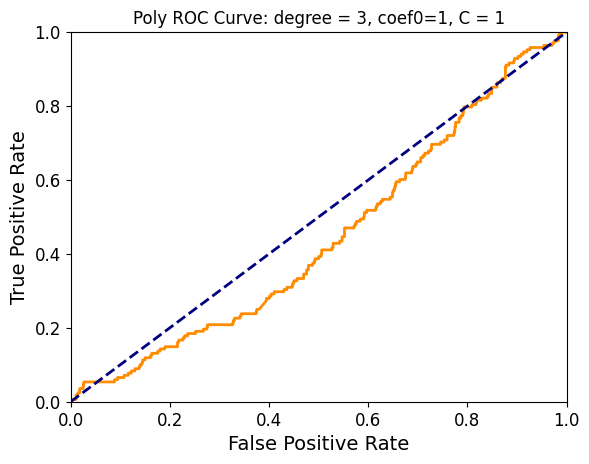

In [ ]:
c_param = 1
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Training Data ROC Curve:

Threshold: 0.0
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.05
Confusion matrix:
[[ 297 3082]
 [   1 3383]]
Threshold: 0.1
Confusion matrix:
[[ 443 2936]
 [   2 3382]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 577 2802]
 [   3 3381]]
Threshold: 0.2
Confusion matrix:
[[1039 2340]
 [  10 3374]]
Threshold: 0.25
Confusion matrix:
[[1217 2162]
 [  31 3353]]
Threshold: 0.30000000000000004
Confusion matrix:
[[1415 1964]
 [  74 3310]]
Threshold: 0.35000000000000003
Confusion matrix:
[[1600 1779]
 [ 113 3271]]
Threshold: 0.4
Confusion matrix:
[[1851 1528]
 [ 185 3199]]
Threshold: 0.45
Confusion matrix:
[[2104 1275]
 [ 307 3077]]
Threshold: 0.5
Confusion matrix:
[[2352 1027]
 [ 498 2886]]
Threshold: 0.55
Confusion matrix:
[[2626  753]
 [ 809 2575]]
Threshold: 0.6000000000000001
Confusion matrix:
[[2934  445]
 [1214 2170]]
Threshold: 0.65
Confusion matrix:
[[3223  156]
 [1881 1503]]
Threshold: 0.7000000000000001
Confusion matrix:
[[3314   65]
 [2709  675]]
Threshold: 0.75
C

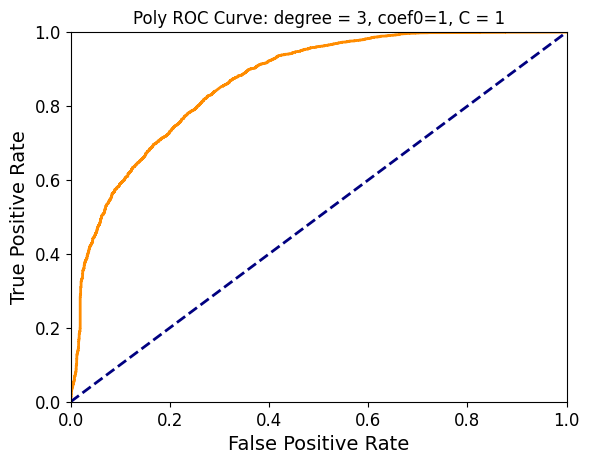

In [17]:
c_param = 1
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_train_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_train_resampled, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[165 661]
 [ 35 133]]
Threshold: 0.1
Confusion matrix:
[[233 593]
 [ 49 119]]
Threshold: 0.15000000000000002
Confusion matrix:
[[279 547]
 [ 64 104]]
Threshold: 0.2
Confusion matrix:
[[331 495]
 [ 76  92]]
Threshold: 0.25
Confusion matrix:
[[375 451]
 [ 85  83]]
Threshold: 0.30000000000000004
Confusion matrix:
[[427 399]
 [ 96  72]]
Threshold: 0.35000000000000003
Confusion matrix:
[[470 356]
 [101  67]]
Threshold: 0.4
Confusion matrix:
[[515 311]
 [111  57]]
Threshold: 0.45
Confusion matrix:
[[561 265]
 [122  46]]
Threshold: 0.5
Confusion matrix:
[[593 233]
 [131  37]]
Threshold: 0.55
Confusion matrix:
[[645 181]
 [132  36]]
Threshold: 0.6000000000000001
Confusion matrix:
[[700 126]
 [138  30]]
Threshold: 0.65
Confusion matrix:
[[730  96]
 [144  24]]
Threshold: 0.7000000000000001
Confusion matrix:
[[751  75]
 [147  21]]
Threshold: 0.75
Confusion matrix:
[[770  56]
 [152  16]]
Threshold: 0.8
Confu

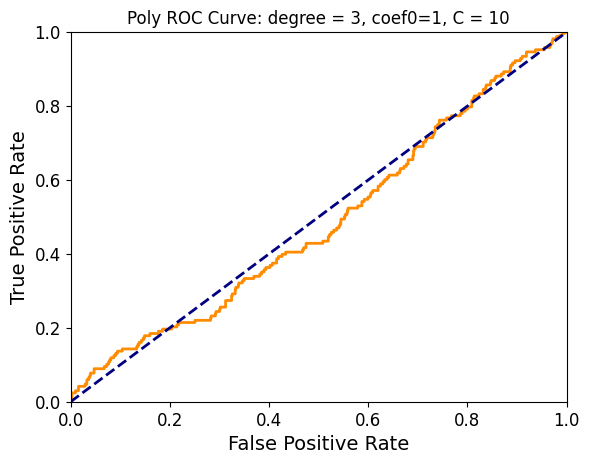

In [ ]:
c_param = 10
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 55 771]
 [ 11 157]]
Threshold: 0.1
Confusion matrix:
[[ 82 744]
 [ 14 154]]
Threshold: 0.15000000000000002
Confusion matrix:
[[111 715]
 [ 17 151]]
Threshold: 0.2
Confusion matrix:
[[142 684]
 [ 26 142]]
Threshold: 0.25
Confusion matrix:
[[171 655]
 [ 42 126]]
Threshold: 0.30000000000000004
Confusion matrix:
[[207 619]
 [ 57 111]]
Threshold: 0.35000000000000003
Confusion matrix:
[[260 566]
 [ 67 101]]
Threshold: 0.4
Confusion matrix:
[[319 507]
 [ 82  86]]
Threshold: 0.45
Confusion matrix:
[[393 433]
 [ 94  74]]
Threshold: 0.5
Confusion matrix:
[[466 360]
 [106  62]]
Threshold: 0.55
Confusion matrix:
[[596 230]
 [133  35]]
Threshold: 0.6000000000000001
Confusion matrix:
[[694 132]
 [145  23]]
Threshold: 0.65
Confusion matrix:
[[749  77]
 [155  13]]
Threshold: 0.7000000000000001
Confusion matrix:
[[787  39]
 [163   5]]
Threshold: 0.75
Confusion matrix:
[[807  19]
 [166   2]]
Threshold: 0.8
Confu

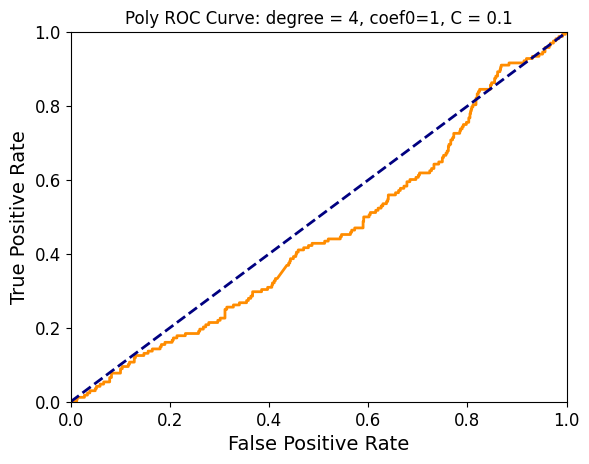

In [ ]:
c_param = 0.1
deg = 4
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[144 682]
 [ 30 138]]
Threshold: 0.1
Confusion matrix:
[[190 636]
 [ 41 127]]
Threshold: 0.15000000000000002
Confusion matrix:
[[233 593]
 [ 49 119]]
Threshold: 0.2
Confusion matrix:
[[279 547]
 [ 61 107]]
Threshold: 0.25
Confusion matrix:
[[319 507]
 [ 72  96]]
Threshold: 0.30000000000000004
Confusion matrix:
[[367 459]
 [ 83  85]]
Threshold: 0.35000000000000003
Confusion matrix:
[[423 403]
 [101  67]]
Threshold: 0.4
Confusion matrix:
[[478 348]
 [113  55]]
Threshold: 0.45
Confusion matrix:
[[522 304]
 [125  43]]
Threshold: 0.5
Confusion matrix:
[[577 249]
 [131  37]]
Threshold: 0.55
Confusion matrix:
[[651 175]
 [142  26]]
Threshold: 0.6000000000000001
Confusion matrix:
[[692 134]
 [144  24]]
Threshold: 0.65
Confusion matrix:
[[732  94]
 [155  13]]
Threshold: 0.7000000000000001
Confusion matrix:
[[755  71]
 [159   9]]
Threshold: 0.75
Confusion matrix:
[[774  52]
 [161   7]]
Threshold: 0.8
Confu

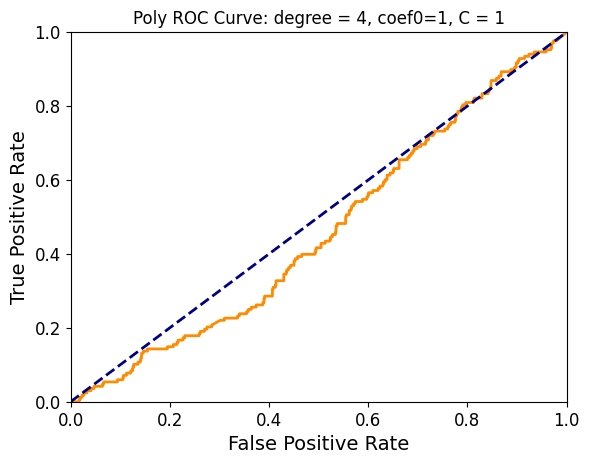

In [ ]:
c_param = 1
deg = 4
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[173 653]
 [ 38 130]]
Threshold: 0.1
Confusion matrix:
[[224 602]
 [ 50 118]]
Threshold: 0.15000000000000002
Confusion matrix:
[[271 555]
 [ 56 112]]
Threshold: 0.2
Confusion matrix:
[[318 508]
 [ 70  98]]
Threshold: 0.25
Confusion matrix:
[[357 469]
 [ 83  85]]
Threshold: 0.30000000000000004
Confusion matrix:
[[411 415]
 [101  67]]
Threshold: 0.35000000000000003
Confusion matrix:
[[467 359]
 [106  62]]
Threshold: 0.4
Confusion matrix:
[[537 289]
 [117  51]]
Threshold: 0.45
Confusion matrix:
[[621 205]
 [128  40]]
Threshold: 0.5
Confusion matrix:
[[667 159]
 [136  32]]
Threshold: 0.55
Confusion matrix:
[[698 128]
 [141  27]]
Threshold: 0.6000000000000001
Confusion matrix:
[[723 103]
 [150  18]]
Threshold: 0.65
Confusion matrix:
[[745  81]
 [153  15]]
Threshold: 0.7000000000000001
Confusion matrix:
[[750  76]
 [155  13]]
Threshold: 0.75
Confusion matrix:
[[769  57]
 [158  10]]
Threshold: 0.8
Confu

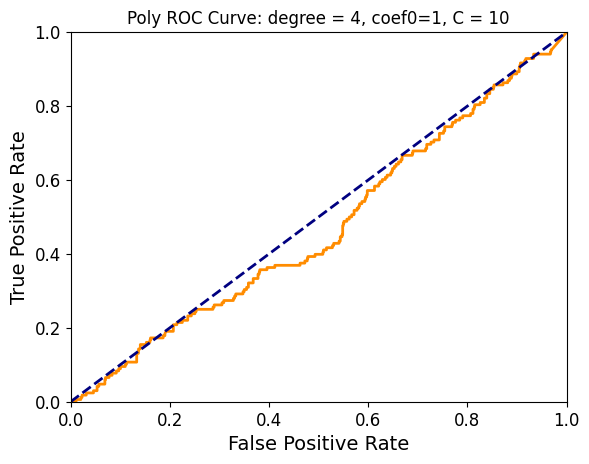

In [ ]:
c_param = 10
deg = 4
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 69 757]
 [ 20 148]]
Threshold: 0.1
Confusion matrix:
[[108 718]
 [ 25 143]]
Threshold: 0.15000000000000002
Confusion matrix:
[[135 691]
 [ 31 137]]
Threshold: 0.2
Confusion matrix:
[[156 670]
 [ 36 132]]
Threshold: 0.25
Confusion matrix:
[[189 637]
 [ 44 124]]
Threshold: 0.30000000000000004
Confusion matrix:
[[243 583]
 [ 59 109]]
Threshold: 0.35000000000000003
Confusion matrix:
[[288 538]
 [ 61 107]]
Threshold: 0.4
Confusion matrix:
[[369 457]
 [ 77  91]]
Threshold: 0.45
Confusion matrix:
[[484 342]
 [101  67]]
Threshold: 0.5
Confusion matrix:
[[615 211]
 [117  51]]
Threshold: 0.55
Confusion matrix:
[[704 122]
 [141  27]]
Threshold: 0.6000000000000001
Confusion matrix:
[[754  72]
 [151  17]]
Threshold: 0.65
Confusion matrix:
[[771  55]
 [158  10]]
Threshold: 0.7000000000000001
Confusion matrix:
[[784  42]
 [163   5]]
Threshold: 0.75
Confusion matrix:
[[796  30]
 [165   3]]
Threshold: 0.8
Confu

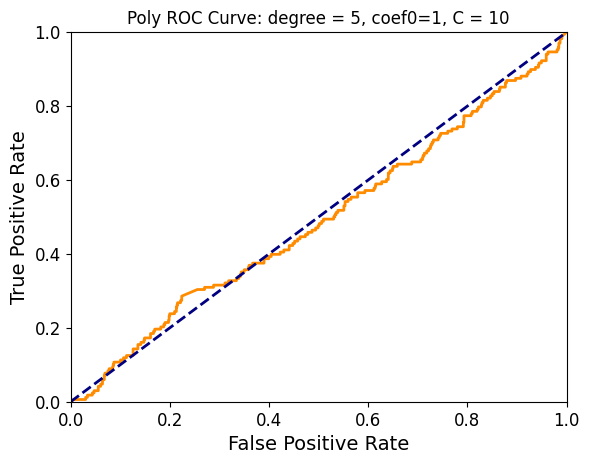

In [ ]:
c_param = 10
deg = 5
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  2 824]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  4 822]
 [  1 167]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  4 822]
 [  1 167]]
Threshold: 0.2
Confusion matrix:
[[  5 821]
 [  2 166]]
Threshold: 0.25
Confusion matrix:
[[  7 819]
 [  2 166]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  8 818]
 [  3 165]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 11 815]
 [  5 163]]
Threshold: 0.4
Confusion matrix:
[[ 25 801]
 [ 10 158]]
Threshold: 0.45
Confusion matrix:
[[ 52 774]
 [ 15 153]]
Threshold: 0.5
Confusion matrix:
[[261 565]
 [ 62 106]]
Threshold: 0.55
Confusion matrix:
[[809  17]
 [167   1]]
Threshold: 0.6000000000000001
Confusion matrix:
[[817   9]
 [167   1]]
Threshold: 0.65
Confusion matrix:
[[820   6]
 [167   1]]
Threshold: 0.7000000000000001
Confusion matrix:
[[821   5]
 [167   1]]
Threshold: 0.75
Confusion matrix:
[[823   3]
 [167   1]]
Threshold: 0.8
Confu

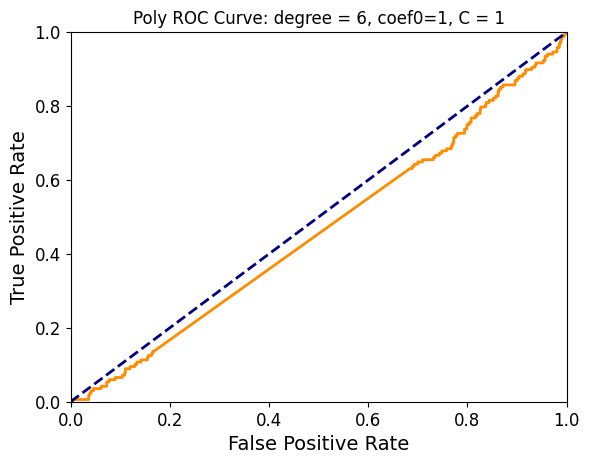

In [ ]:
c_param = 1
deg = 6
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[  5 821]
 [  1 167]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

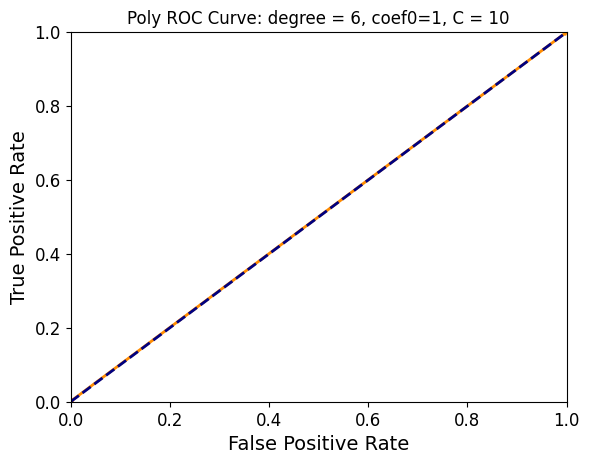

In [ ]:
c_param = 10
deg = 6
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

## 2.3 Gaussian Kernel

### Gaussian kernels tend to be around the coin-flip, although some are very slightly better.

### I don't play with larger parameters becasue of computation time.

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  2 824]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[ 28 798]
 [  1 167]]
Threshold: 0.25
Confusion matrix:
[[207 619]
 [ 39 129]]
Threshold: 0.30000000000000004
Confusion matrix:
[[378 448]
 [ 71  97]]
Threshold: 0.35000000000000003
Confusion matrix:
[[462 364]
 [ 91  77]]
Threshold: 0.4
Confusion matrix:
[[525 301]
 [115  53]]
Threshold: 0.45
Confusion matrix:
[[579 247]
 [128  40]]
Threshold: 0.5
Confusion matrix:
[[620 206]
 [136  32]]
Threshold: 0.55
Confusion matrix:
[[656 170]
 [143  25]]
Threshold: 0.6000000000000001
Confusion matrix:
[[695 131]
 [149  19]]
Threshold: 0.65
Confusion matrix:
[[721 105]
 [152  16]]
Threshold: 0.7000000000000001
Confusion matrix:
[[746  80]
 [156  12]]
Threshold: 0.75
Confusion matrix:
[[769  57]
 [160   8]]
Threshold: 0.8
Confu

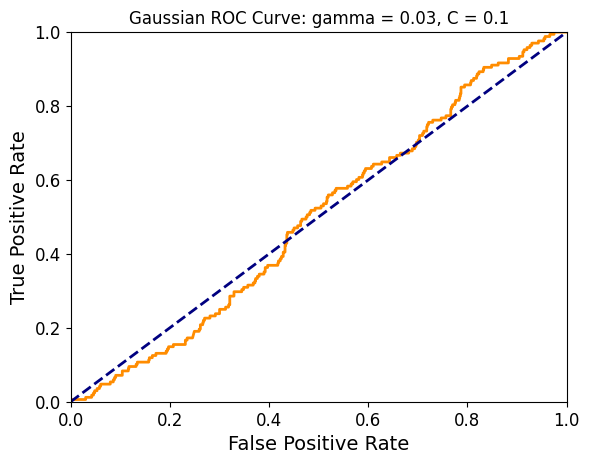

In [ ]:
g_param = 0.03
c_param = 0.1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 67 759]
 [  2 166]]
Threshold: 0.1
Confusion matrix:
[[ 69 757]
 [  3 165]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 70 756]
 [  3 165]]
Threshold: 0.2
Confusion matrix:
[[ 70 756]
 [  3 165]]
Threshold: 0.25
Confusion matrix:
[[ 72 754]
 [  4 164]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 74 752]
 [  6 162]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 83 743]
 [  6 162]]
Threshold: 0.4
Confusion matrix:
[[815  11]
 [167   1]]
Threshold: 0.45
Confusion matrix:
[[822   4]
 [168   0]]
Threshold: 0.5
Confusion matrix:
[[823   3]
 [168   0]]
Threshold: 0.55
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

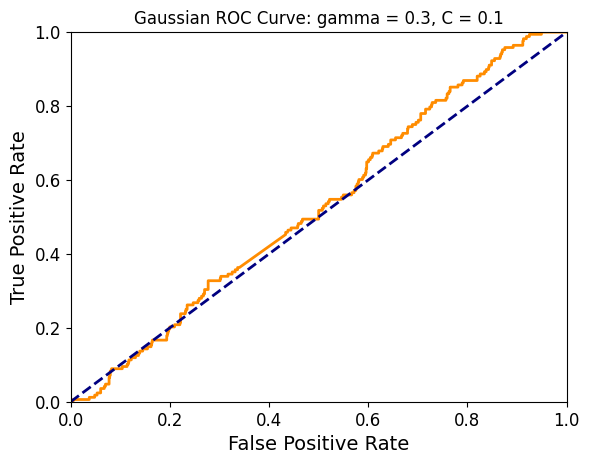

In [ ]:
g_param = 0.3
c_param = 0.1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc}')
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
# plt.legend()
plt.show()

Training Data ROC Curve:

Threshold: 0.0
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.05
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.1
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.15000000000000002
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.2
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.25
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.30000000000000004
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.35000000000000003
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.4
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.45
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.5
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.55
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.6000000000000001
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.65
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.7000000000000001
Confusion matrix:
[[3379    0]
 [   0 3384]]
Threshold: 0.75
C

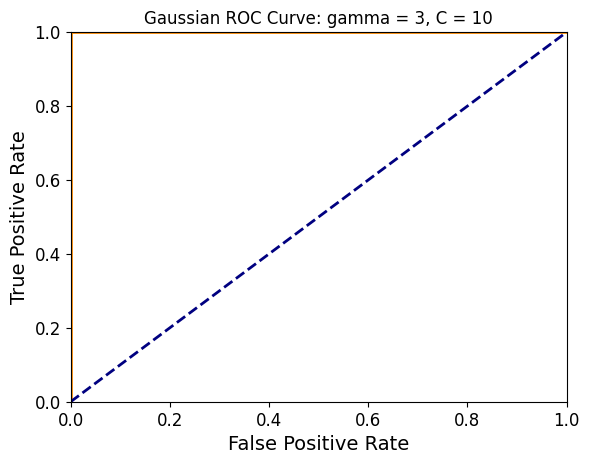

In [25]:
g_param = 3
c_param = 10

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_train_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_train_resampled, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

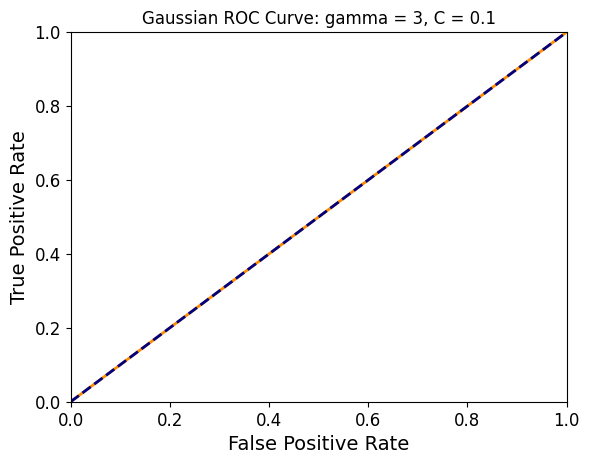

In [ ]:
g_param = 3
c_param = 0.1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[523 303]
 [106  62]]
Threshold: 0.1
Confusion matrix:
[[637 189]
 [131  37]]
Threshold: 0.15000000000000002
Confusion matrix:
[[678 148]
 [139  29]]
Threshold: 0.2
Confusion matrix:
[[707 119]
 [143  25]]
Threshold: 0.25
Confusion matrix:
[[725 101]
 [146  22]]
Threshold: 0.30000000000000004
Confusion matrix:
[[740  86]
 [148  20]]
Threshold: 0.35000000000000003
Confusion matrix:
[[750  76]
 [148  20]]
Threshold: 0.4
Confusion matrix:
[[759  67]
 [151  17]]
Threshold: 0.45
Confusion matrix:
[[769  57]
 [154  14]]
Threshold: 0.5
Confusion matrix:
[[775  51]
 [155  13]]
Threshold: 0.55
Confusion matrix:
[[781  45]
 [158  10]]
Threshold: 0.6000000000000001
Confusion matrix:
[[785  41]
 [158  10]]
Threshold: 0.65
Confusion matrix:
[[788  38]
 [158  10]]
Threshold: 0.7000000000000001
Confusion matrix:
[[797  29]
 [159   9]]
Threshold: 0.75
Confusion matrix:
[[801  25]
 [161   7]]
Threshold: 0.8
Confu

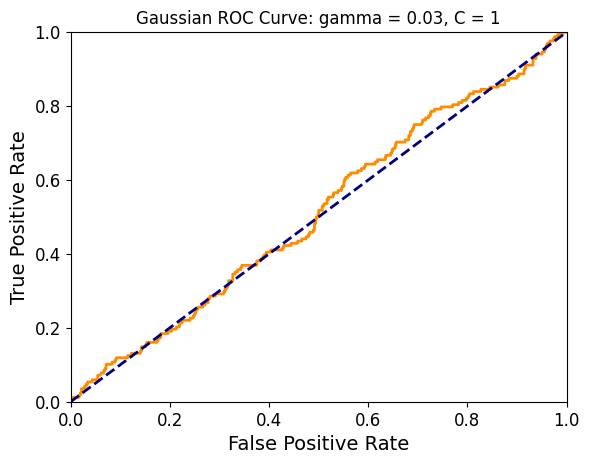

In [ ]:
g_param = 0.03
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[794  32]
 [165   3]]
Threshold: 0.1
Confusion matrix:
[[814  12]
 [167   1]]
Threshold: 0.15000000000000002
Confusion matrix:
[[816  10]
 [167   1]]
Threshold: 0.2
Confusion matrix:
[[817   9]
 [168   0]]
Threshold: 0.25
Confusion matrix:
[[817   9]
 [168   0]]
Threshold: 0.30000000000000004
Confusion matrix:
[[818   8]
 [168   0]]
Threshold: 0.35000000000000003
Confusion matrix:
[[819   7]
 [168   0]]
Threshold: 0.4
Confusion matrix:
[[819   7]
 [168   0]]
Threshold: 0.45
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.5
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.55
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[821   5]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[822   4]
 [168   0]]
Threshold: 0.8
Confu

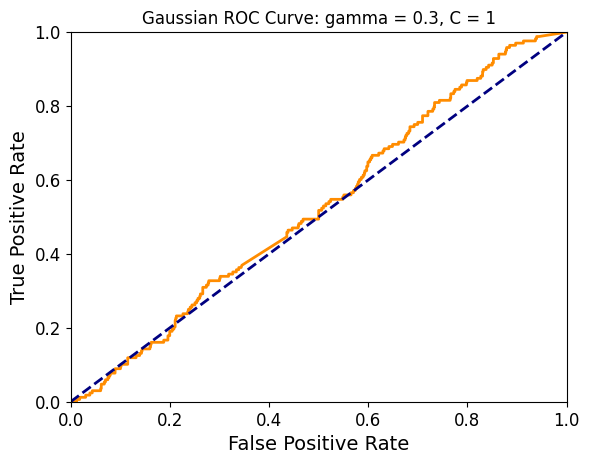

In [ ]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 22 804]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[ 32 794]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[824   2]
 [168   0]]
Threshold: 0.2
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.25
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.30000000000000004
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.35000000000000003
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.4
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.45
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.5
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

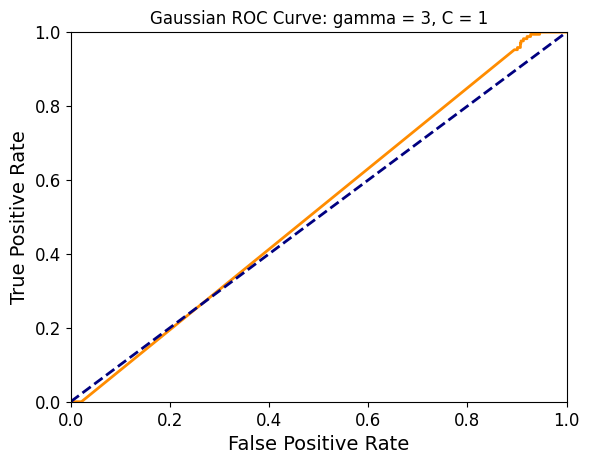

In [ ]:
g_param = 3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 16 810]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[ 22 804]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 27 799]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[ 41 785]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.30000000000000004
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.35000000000000003
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.4
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.45
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.5
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

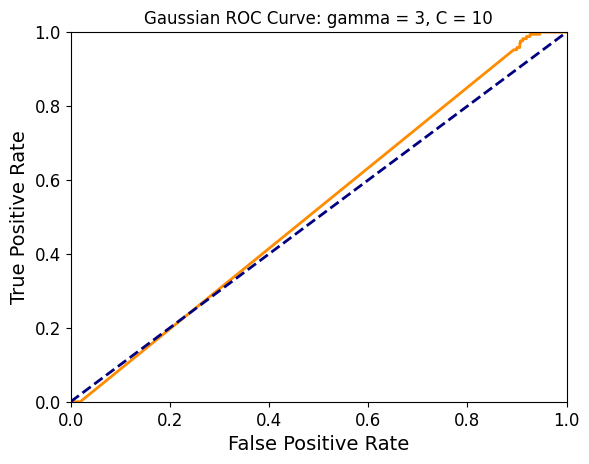

In [ ]:
g_param = 3
c_param = 10

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 25 801]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[ 41 785]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.2
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.25
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.30000000000000004
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.35000000000000003
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.4
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.45
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.5
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

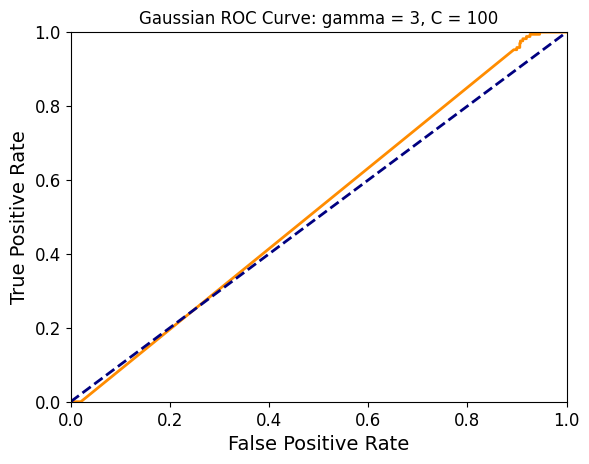

In [ ]:
g_param = 3
c_param = 100

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

## 2.4 Sigmoid Kernel

### Sigmoid kernels seem to be the best, at least sometimes being somewhat better than the coin-flip. The best sigmoid model has gamma=3, C=10.

### I don't play with larger parameters becasue of computation time.

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[241 585]
 [ 51 117]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

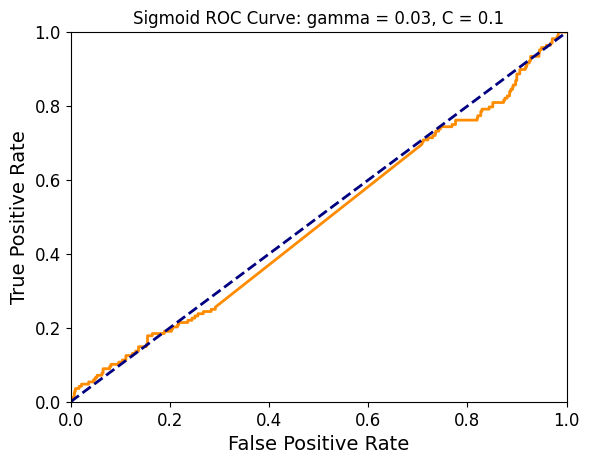

In [ ]:
g_param = 0.03
c_param = 0.1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[232 594]
 [ 55 113]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

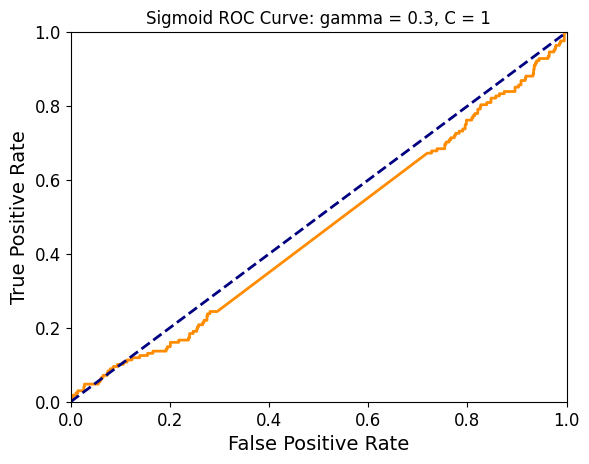

In [ ]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

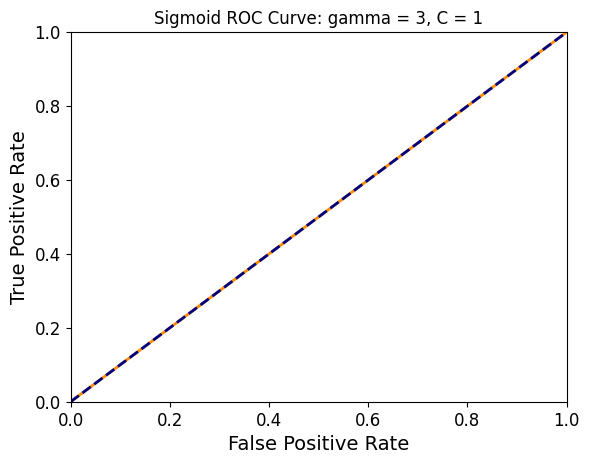

In [ ]:
g_param = 3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[ 86 740]
 [ 17 151]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

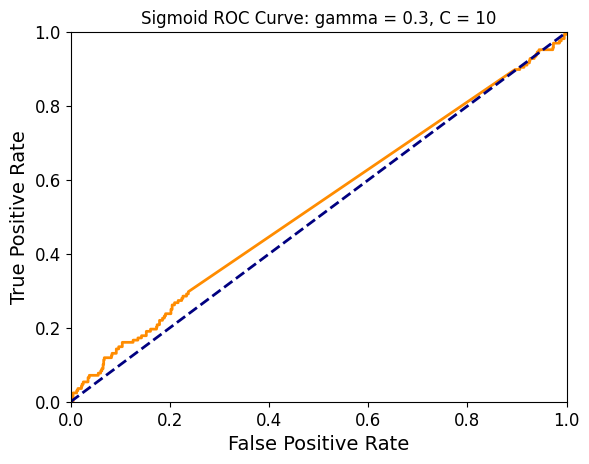

In [ ]:
g_param = 0.3
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[268 558]
 [ 46 122]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

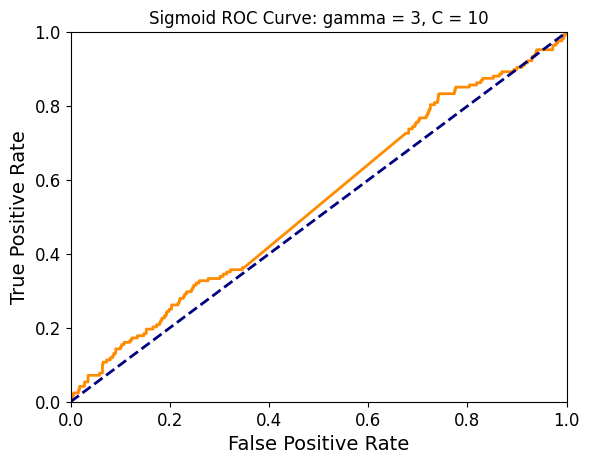

In [ ]:
g_param = 3
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Training Data ROC Curve:

Threshold: 0.0
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.05
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.1
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.15000000000000002
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.2
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.25
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.30000000000000004
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.35000000000000003
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.4
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.45
Confusion matrix:
[[   0 3379]
 [   0 3384]]
Threshold: 0.5
Confusion matrix:
[[ 739 2640]
 [ 787 2597]]
Threshold: 0.55
Confusion matrix:
[[3379    0]
 [3384    0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[3379    0]
 [3384    0]]
Threshold: 0.65
Confusion matrix:
[[3379    0]
 [3384    0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[3379    0]
 [3384    0]]
Threshold: 0.75
C

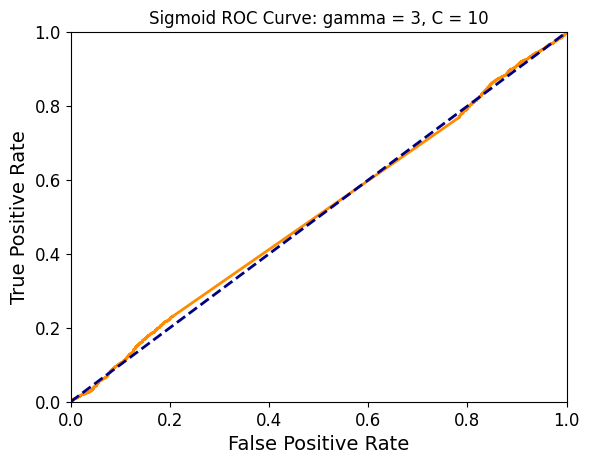

In [26]:
g_param = 3
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_train_resampled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_resampled, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_train_resampled, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[147 679]
 [ 35 133]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

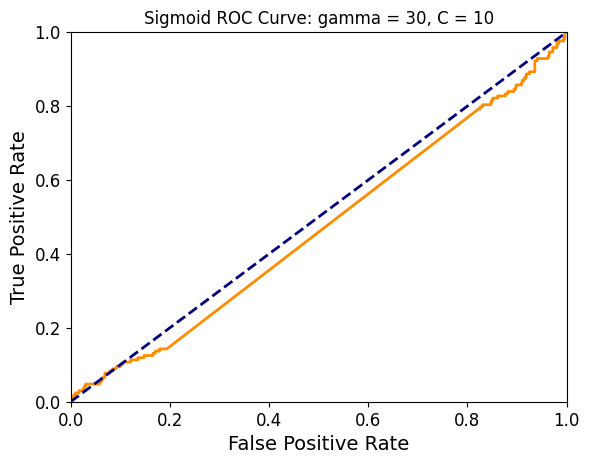

In [ ]:
g_param = 30
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[102 724]
 [ 29 139]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

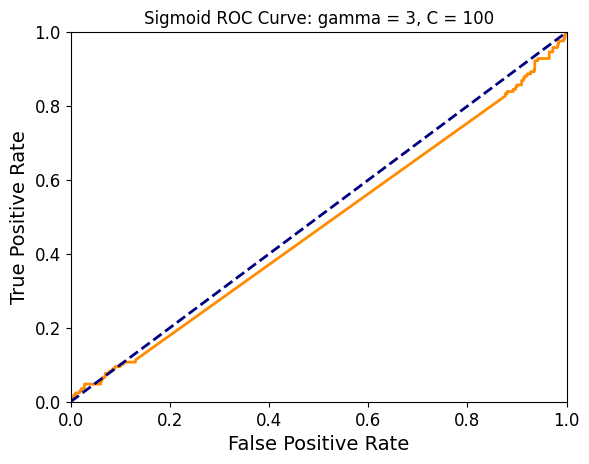

In [ ]:
g_param = 3
c_param = 100

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

# 3. Polynomial Kernels w/o Probability

## Since the polynomial kernels were improving at higher degrees, I wondered if this trend might continue and provide a useful model at a higher degree. High degress required more computation time, so I needed to turn off the probability hyperparameter. In order to track which model was the best, I calculated the distance from each models (fpr, tpr) to coin-flip line, then printed the max distance and the degree kernel that corresponded to it. I tried this for a few values of C. It turned out that the highest degree kernel was always the winner, and the higher C was, the better the model was. this would be great news, but the models were still bad, regardless of degree or the value of C, and going to higher degrees was not feasible computationally. So, this overall proved unsuccessful.

### Polynomial Kernel

[[474 352]
 [103  65]]
[[577 249]
 [125  43]]
[[626 200]
 [130  38]]
[[645 181]
 [132  36]]
[[652 174]
 [136  32]]
[[656 170]
 [135  33]]
[[661 165]
 [133  35]]
[[661 165]
 [135  33]]
[[651 175]
 [134  34]]
[[648 178]
 [133  35]]
[[635 191]
 [130  38]]
[[633 193]
 [131  37]]
[[635 191]
 [129  39]]
[[632 194]
 [132  36]]
[[631 195]
 [130  38]]
[[634 192]
 [130  38]]
[[638 188]
 [129  39]]
[[634 192]
 [128  40]]
[[632 194]
 [128  40]]
[[627 199]
 [131  37]]
[[619 207]
 [130  38]]
[[616 210]
 [130  38]]
[[613 213]
 [131  37]]
[[615 211]
 [132  36]]
[[610 216]
 [130  38]]
[[606 220]
 [130  38]]
Degree for Max Distance: 30
Max Distance: 0.0022828306091575226


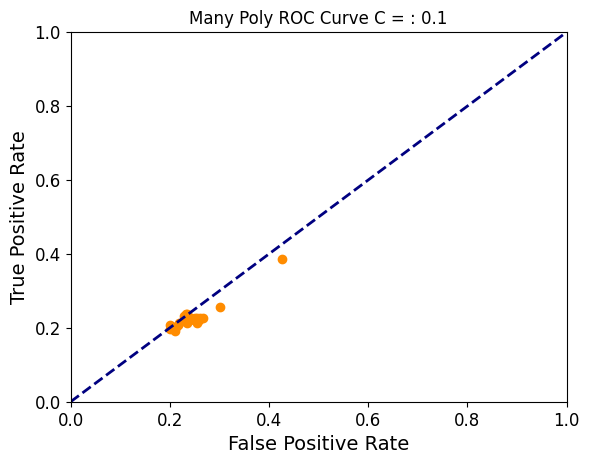

In [ ]:
c_param = 0.1
c0 = 1
max_distance = 0
hyperplane = np.array([1, -1])



for j in range(26):
  deg = j+5

  poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=deg, coef0=c0, C=c_param)
  )
  poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)

  cm = confusion_matrix(y_test, poly_kernel_svm_clf.predict(X_test))
  print(cm)
  tn, fp, fn, tp = cm.ravel()
  fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]


  if (fpr<tpr):
    # Define the hyperplane and the point
    point = np.array([fpr, tpr])

    # Calculate the distance from the point to the hyperplane
    distance = np.abs(np.dot(hyperplane, point)) / np.linalg.norm(hyperplane[:2])

    if (distance > max_distance):
      max_distance = distance
      max_d_deg = deg



  # Plot the ROC curve
  plt.scatter(fpr, tpr, color='darkorange', label=f'{deg}, {c_param}')


print("Degree for Max Distance:", deg)
print("Max Distance:", distance)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Many Poly ROC Curve C = {c_param}')
plt.show()

[[641 185]
 [132  36]]
[[660 166]
 [136  32]]
[[649 177]
 [135  33]]
[[657 169]
 [135  33]]
[[649 177]
 [134  34]]
[[649 177]
 [134  34]]
[[635 191]
 [129  39]]
[[636 190]
 [129  39]]
[[637 189]
 [126  42]]
[[637 189]
 [127  41]]
[[641 185]
 [129  39]]
[[644 182]
 [127  41]]
[[632 194]
 [124  44]]
[[626 200]
 [124  44]]
[[622 204]
 [122  46]]
Degree for Max Distance: 20
Max Distance: 0.018976029438622057


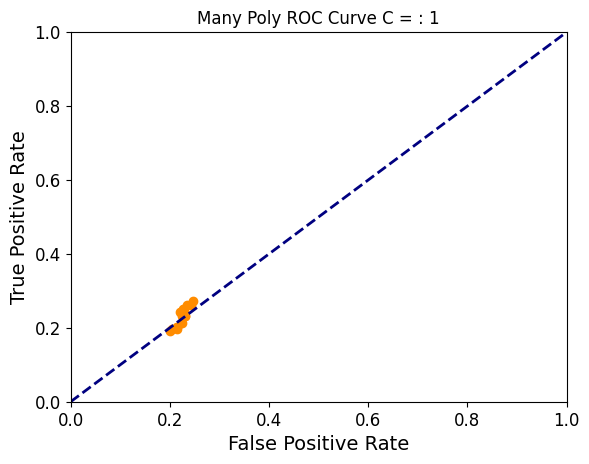

In [ ]:
c_param = 1
c0 = 1
max_distance = 0
hyperplane = np.array([1, -1])



for j in range(16):
  deg = j+5

  poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=deg, coef0=c0, C=c_param)
  )
  poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)

  cm = confusion_matrix(y_test, poly_kernel_svm_clf.predict(X_test))
  print(cm)
  tn, fp, fn, tp = cm.ravel()
  fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]


  if (fpr<tpr):
    # Define the hyperplane and the point
    point = np.array([fpr, tpr])

    # Calculate the distance from the point to the hyperplane
    distance = np.abs(np.dot(hyperplane, point)) / np.linalg.norm(hyperplane[:2])

    if (distance > max_distance):
      max_distance = distance
      max_d_deg = deg



  # Plot the ROC curve
  plt.scatter(fpr, tpr, color='darkorange', label=f'{deg}, {c_param}')


print("Degree for Max Distance:", deg)
print("Max Distance:", distance)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Many Poly ROC Curve C = {c_param}')
plt.show()

[[651 175]
 [127  41]]
[[630 196]
 [129  39]]
[[632 194]
 [131  37]]
[[642 184]
 [129  39]]
[[641 185]
 [129  39]]
[[627 199]
 [124  44]]
[[627 199]
 [123  45]]
[[614 212]
 [122  46]]
[[613 213]
 [125  43]]
[[610 216]
 [121  47]]
[[608 218]
 [119  49]]
Degree for Max Distance: 15
Max Distance: 0.019618075547447624


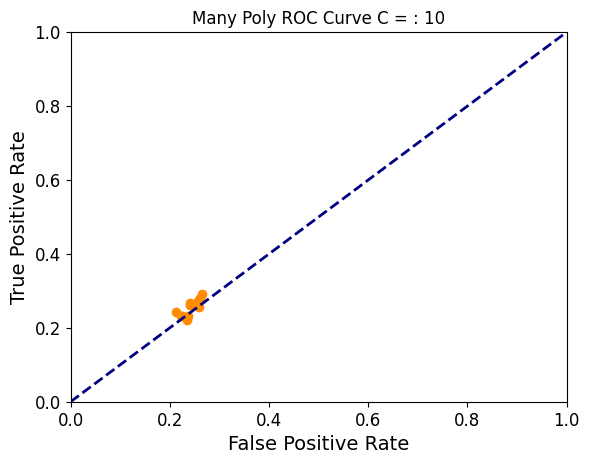

In [ ]:
c_param = 10
c0 = 1
max_distance = 0
hyperplane = np.array([1, -1])



for j in range(11):
  deg = j+5

  poly_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=deg, coef0=c0, C=c_param)
  )
  poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)

  cm = confusion_matrix(y_test, poly_kernel_svm_clf.predict(X_test))
  print(cm)
  tn, fp, fn, tp = cm.ravel()
  fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]


  if (fpr<tpr):
    # Define the hyperplane and the point
    point = np.array([fpr, tpr])

    # Calculate the distance from the point to the hyperplane
    distance = np.abs(np.dot(hyperplane, point)) / np.linalg.norm(hyperplane[:2])

    if (distance > max_distance):
      max_distance = distance
      max_d_deg = deg



  # Plot the ROC curve
  plt.scatter(fpr, tpr, color='darkorange', label=f'{deg}, {c_param}')


print("Degree for Max Distance:", deg)
print("Max Distance:", distance)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Many Poly ROC Curve C = {c_param}')
plt.show()

# 4. Voting Classifier

## By using a hard voting classifier, I was able to get something slightly better than any of my individual models, even though it still was not good. Again, I used distance from the coin-flip line to evaluate a models's performance. Soft Voting predicted almost exclusively black, probably because for each data point, there was a model that felt stronglt that the point was black.

### Best Individual Classifiers Were:

*   Gaussian: gamma=0.3, C=0.1
*   Sigmoid: gamma=0.3, C=10
*   Sigmoid: gamma=3, C=10



## 4.1 Hard Voting

In [ ]:
poly_kernel_svm_clf_voting1 = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=20, coef0=1, C=1)
)

In [ ]:
poly_kernel_svm_clf_voting2 = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=15, coef0=1, C=10)
)

In [ ]:
rbf_kernel_svm_clf_voting1 = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=0.3, C=0.1)
)

In [ ]:
sgm_kernel_svm_clf_voting1 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=0.3, C=10)
)

In [ ]:
sgm_kernel_svm_clf_voting2 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=3, C=10)
)

In [ ]:
hard_voting_clf1 = VotingClassifier(
    estimators=[
        ('poly1', poly_kernel_svm_clf_voting1),
        ('poly2', poly_kernel_svm_clf_voting2),
        ('rbf1', rbf_kernel_svm_clf_voting1),
        ('sgm1', sgm_kernel_svm_clf_voting1),
        ('sgm2', sgm_kernel_svm_clf_voting2),
    ]
)

hard_voting_clf1.fit(X_train_resampled, y_train_resampled)

cm = confusion_matrix(y_test, hard_voting_clf1.predict(X_test))
print(cm)
tn, fp, fn, tp = cm.ravel()
fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]
distance = (tpr-fpr)*np.sqrt(1/2)
print(distance)

[[339 487]
 [ 62 106]]
0.029248767179830916


In [ ]:
rbf_kernel_svm_clf_voting2 = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=0.3, C=1)
)

In [ ]:
sgm_kernel_svm_clf_voting3 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=0.3, C=1)
)

In [ ]:
sgm_kernel_svm_clf_voting4 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=3, C=1)
)

In [ ]:
hard_voting_clf2 = VotingClassifier(
    estimators=[
        ('poly1', poly_kernel_svm_clf_voting1),
        ('poly2', poly_kernel_svm_clf_voting2),
        ('rbf1', rbf_kernel_svm_clf_voting1),
        ('rbf2', rbf_kernel_svm_clf_voting2),
        ('sgm1', sgm_kernel_svm_clf_voting1),
        ('sgm2', sgm_kernel_svm_clf_voting2),
        ('sgm3', sgm_kernel_svm_clf_voting3),
        ('sgm4', sgm_kernel_svm_clf_voting4),
    ]
)

hard_voting_clf2.fit(X_train_resampled, y_train_resampled)

cm = confusion_matrix(y_test, hard_voting_clf2.predict(X_test))
print(cm)
tn, fp, fn, tp = cm.ravel()
fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]
distance = (tpr-fpr)*np.sqrt(1/2)
print(distance)

[[419 407]
 [ 76  92]]
0.03880812035567821


In [ ]:
hard_voting_clf3 = VotingClassifier(
    estimators=[
        ('rbf1', rbf_kernel_svm_clf_voting1),
        ('sgm1', sgm_kernel_svm_clf_voting1),
        ('sgm2', sgm_kernel_svm_clf_voting2),
    ]
)

hard_voting_clf3.fit(X_train_resampled, y_train_resampled)

cm = confusion_matrix(y_test, hard_voting_clf3.predict(X_test))
print(cm)
tn, fp, fn, tp = cm.ravel()
fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]
distance = (tpr-fpr)*np.sqrt(1/2)
print(distance)

[[398 428]
 [ 72  96]]
0.03766670505109939


## 4.2 Soft Voting

In [ ]:
rbf_kernel_svm_clf_softvoting1 = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=0.3, C=0.1, probability=True)
)

In [ ]:
sgm_kernel_svm_clf_softvoting1 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=0.3, C=10, probability=True)
)

In [ ]:
sgm_kernel_svm_clf_softvoting2 = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=3, C=10, probability=True)
)

In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ('rbf1', rbf_kernel_svm_clf_softvoting1),
        ('sgm1', sgm_kernel_svm_clf_softvoting1),
        ('sgm2', sgm_kernel_svm_clf_softvoting2),
    ],
    voting='soft'
)

soft_voting_clf.fit(X_train_resampled, y_train_resampled)

cm = confusion_matrix(y_test, soft_voting_clf.predict(X_test))
print(cm)
tn, fp, fn, tp = cm.ravel()
fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]

[[823   3]
 [167   1]]


# 5. Using Non-Linearities

## Sometimes, performing a nonlinear transformation on the data, like a square, sin, cos, or an exponential, then using that transformed data can prove useful. In this section, I try all those functions with each of the possible kernels. I use one set of hyperparameters to save time. There were some slightly more promising results here, but nothing significant enough to call a success.



## 5.1 Using Sin

In [37]:
train_sin = np.sin(np.pi * X_train_resampled)
test_sin = np.sin(np.pi * X_test)

In [ ]:
print(X_train_resampled.shape)
print(train_sin.shape)
print(X_test.shape)
print(test_sin.shape)

(6763, 245)
(6763, 245)
(994, 245)
(994, 245)


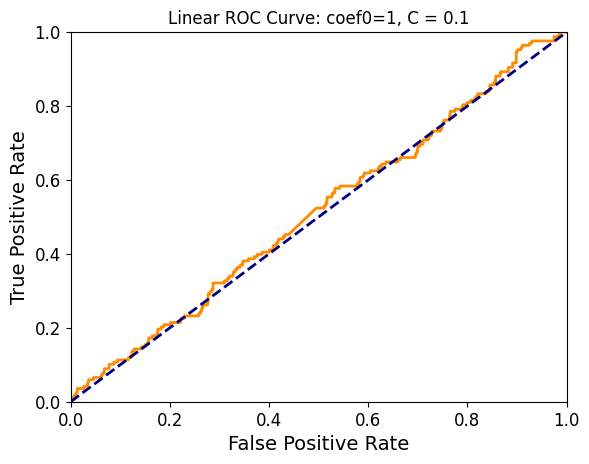

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_sin, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_sin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

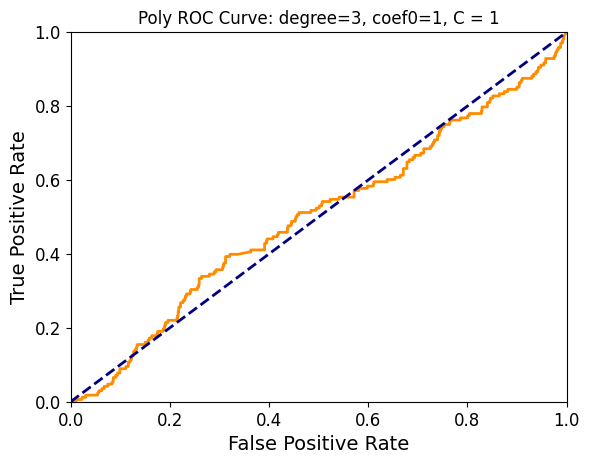

In [ ]:
c_param = 1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=3, coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_sin, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_sin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree=3, coef0=1, C = {c_param}')
plt.show()

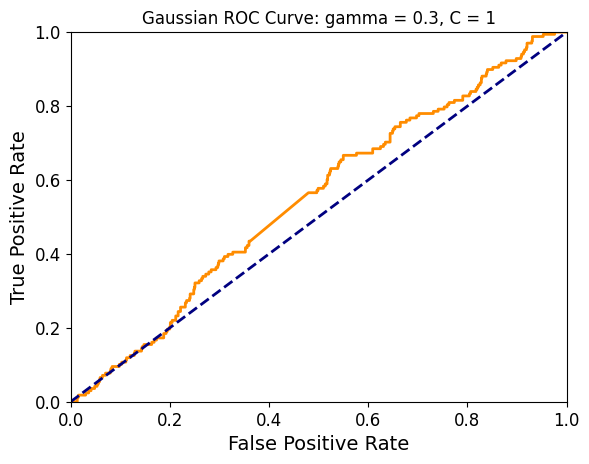

In [39]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train_sin, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(test_sin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

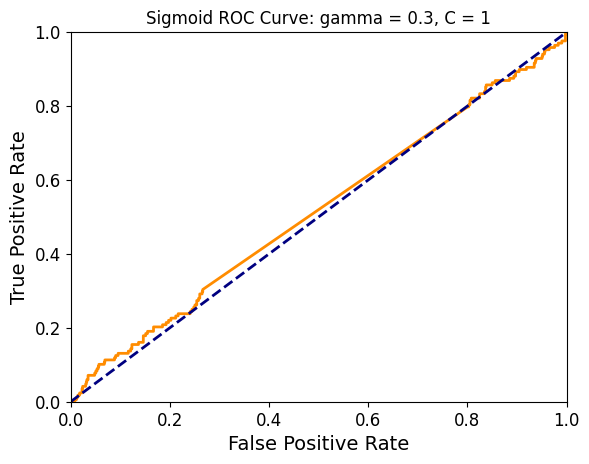

In [40]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train_sin, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(test_sin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

## 5.2 Using Cos

In [41]:
train_cos = np.cos(np.pi * X_train_resampled)
test_cos = np.cos(np.pi * X_test)

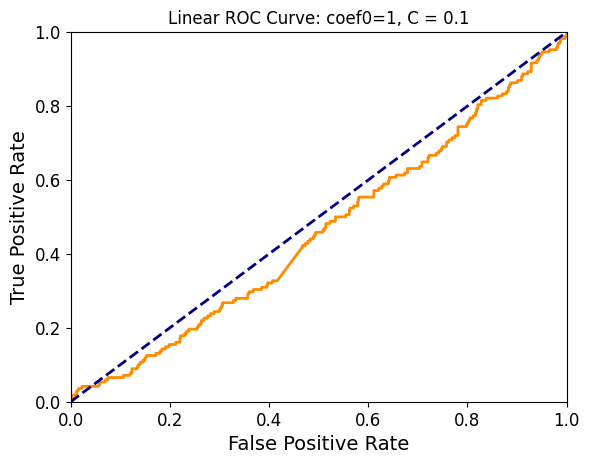

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_cos, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_cos)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

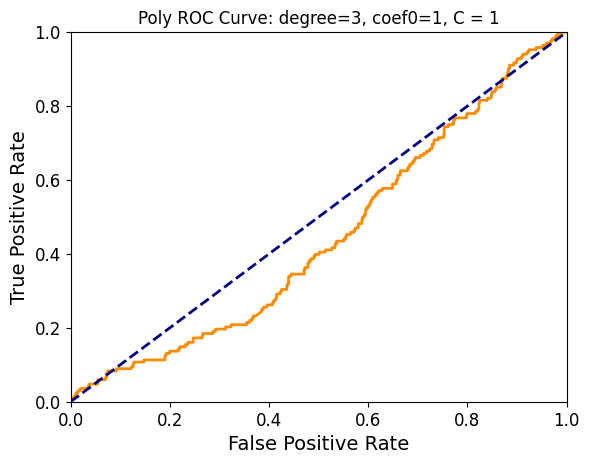

In [ ]:
c_param = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=3, coef0=1, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train_cos, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(test_cos)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree=3, coef0=1, C = {c_param}')
plt.show()

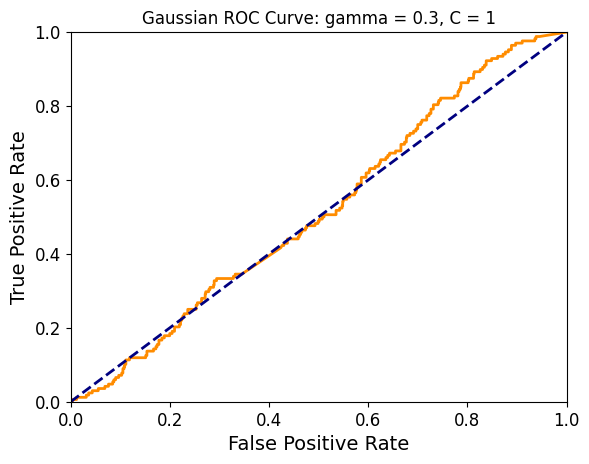

In [42]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train_cos, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(test_cos)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

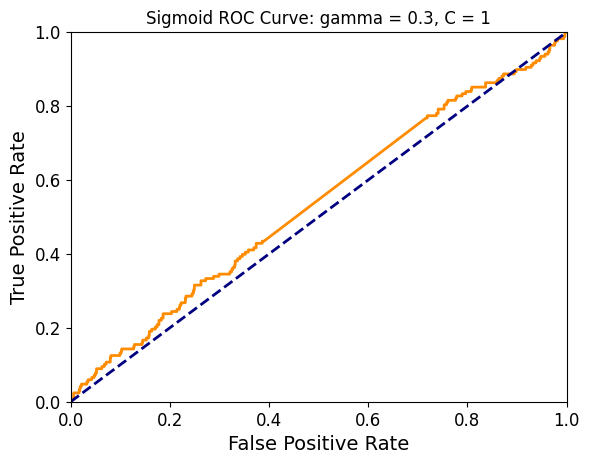

In [43]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train_cos, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(test_cos)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

## 5.3 Using Polynomial

In [44]:
train_poly5 = (X_train_resampled)**5
test_poly5 = (X_test)**5

In [ ]:
print(X_train_resampled.shape)
print(train_poly5.shape)
print(X_test.shape)
print(test_poly5.shape)

(6763, 245)
(6763, 245)
(994, 245)
(994, 245)


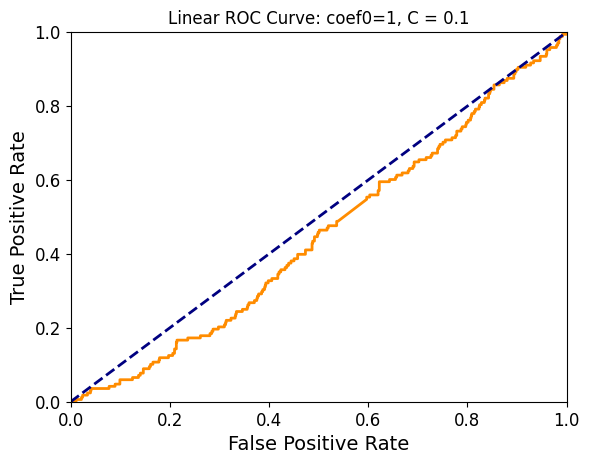

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_poly5, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_poly5)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

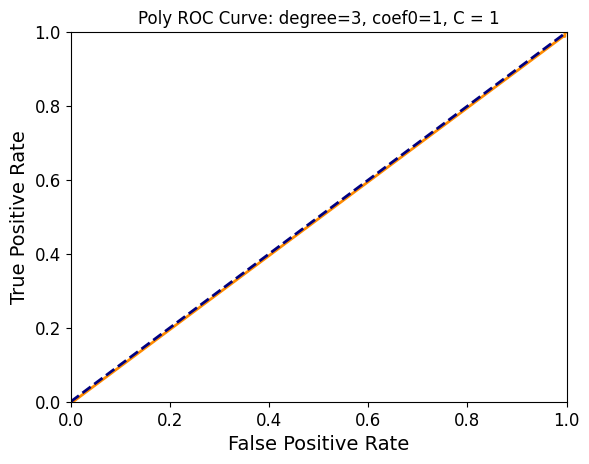

In [ ]:
c_param = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=3, coef0=1, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train_poly5, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(test_poly5)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree=3, coef0=1, C = {c_param}')
plt.show()

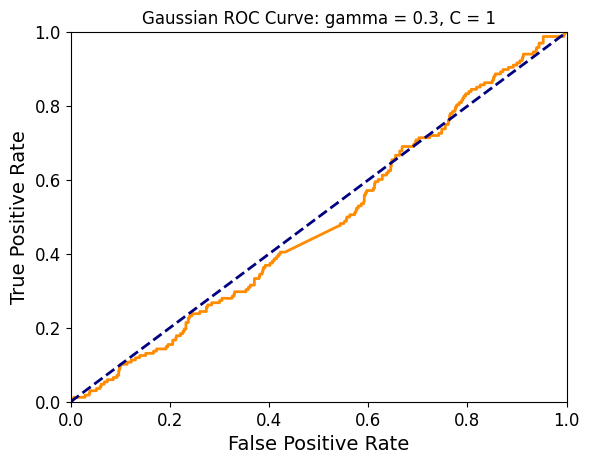

In [45]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train_poly5, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(test_poly5)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

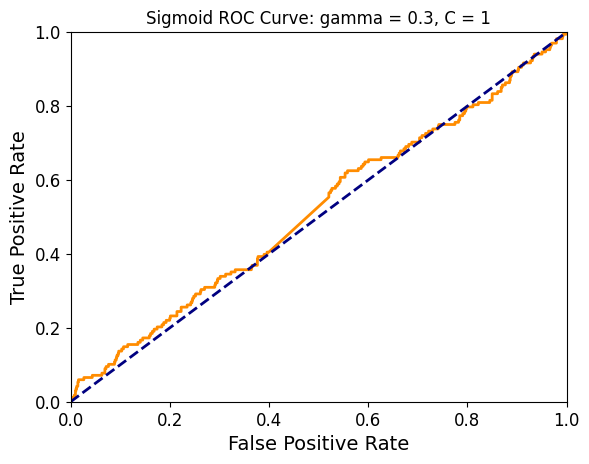

In [46]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train_poly5, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(test_poly5)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

In [47]:
train_poly100 = 10*(X_train_resampled)**100
test_poly100 = 10*(X_test)**100

In [ ]:
print(X_train_resampled.shape)
print(train_poly100.shape)
print(X_test.shape)
print(test_poly100.shape)

(6763, 245)
(6763, 245)
(994, 245)
(994, 245)


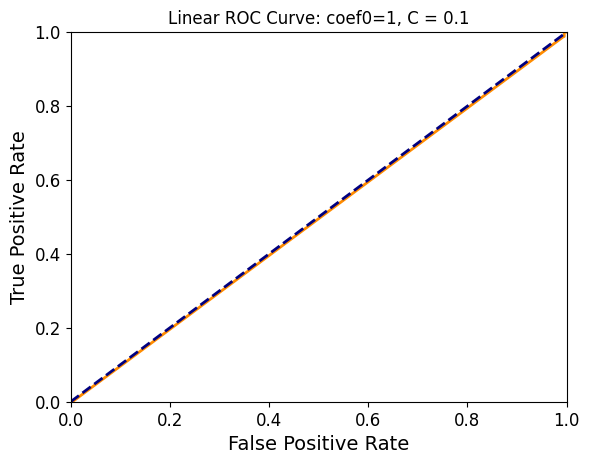

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_poly100, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_poly100)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

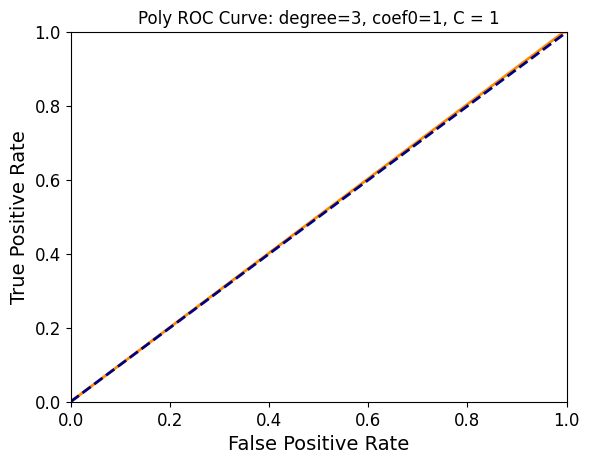

In [ ]:
c_param = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=3, coef0=1, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train_poly100, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(test_poly100)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree=3, coef0=1, C = {c_param}')
plt.show()

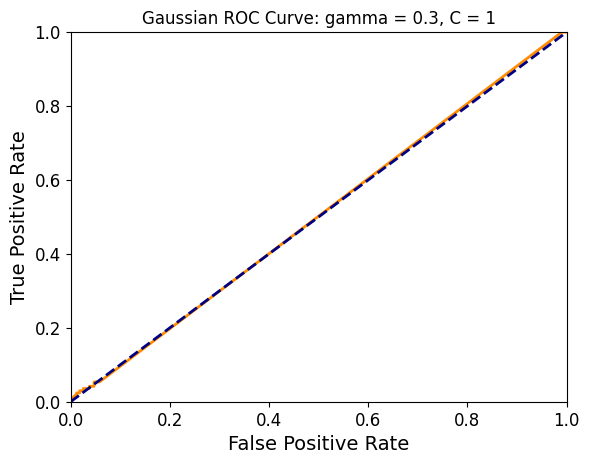

In [48]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train_poly100, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(test_poly100)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

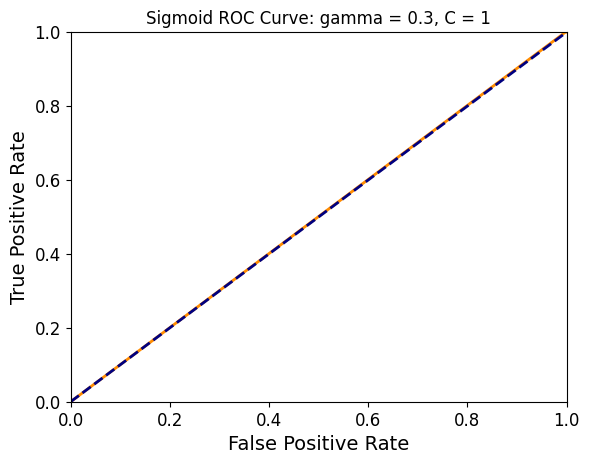

In [49]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train_poly100, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(test_poly100)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

## 5.4 Using Exponential

In [50]:
train_exp = np.exp(X_train_resampled)
test_exp = np.exp(X_test)

In [ ]:
print(X_train_resampled.shape)
print(train_exp.shape)
print(X_test.shape)
print(test_exp.shape)

(6763, 245)
(6763, 245)
(994, 245)
(994, 245)


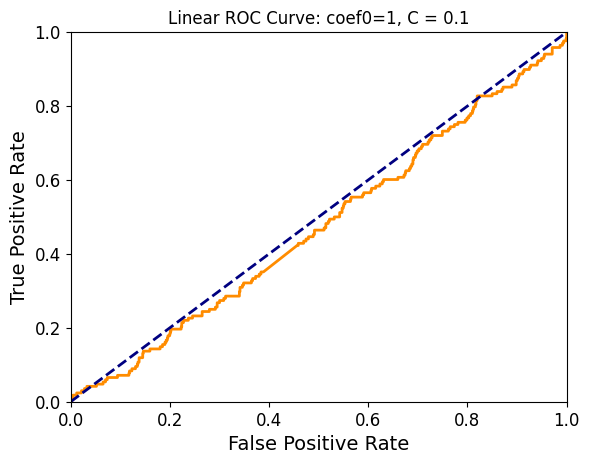

In [ ]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train_exp, y_train_resampled)
y_prob = lin_kernel_svm_clf.predict_proba(test_exp)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

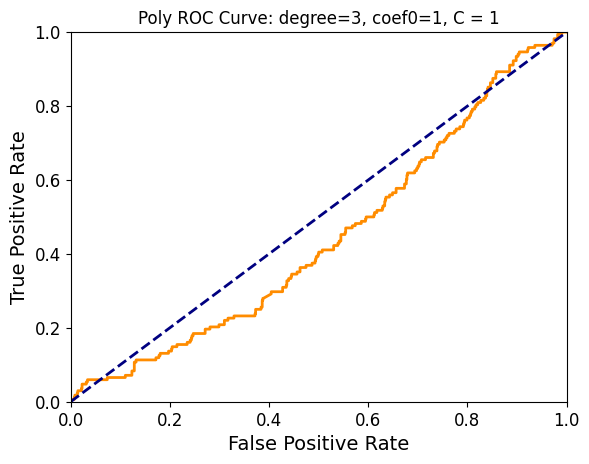

In [ ]:
c_param = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=3, coef0=1, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train_exp, y_train_resampled)
y_prob = poly_kernel_svm_clf.predict_proba(test_exp)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree=3, coef0=1, C = {c_param}')
plt.show()

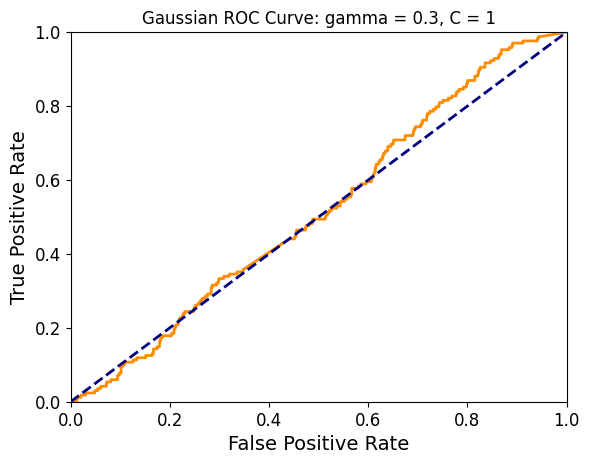

In [51]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train_exp, y_train_resampled)
y_prob = rbf_kernel_svm_clf.predict_proba(test_exp)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

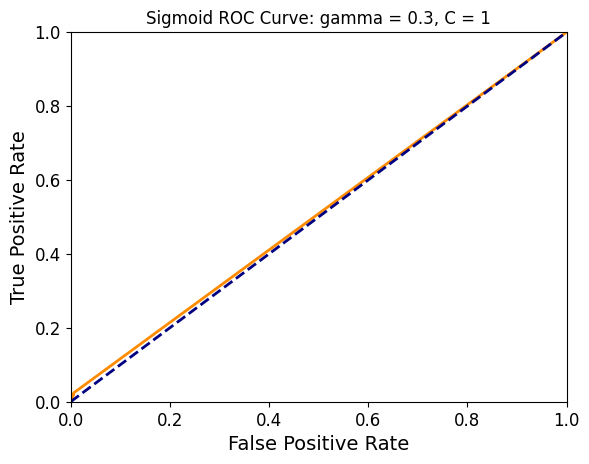

In [52]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train_exp, y_train_resampled)
y_prob = sgm_kernel_svm_clf.predict_proba(test_exp)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

# 6. Flip Probabilities?

## As noted in other sections, some ROC curves were significantly below the coin-flip line. However, any prediction that is worse than a coin flip is better than a coin flip by flipping the prediction. Below is an ROC curve where I reverse the prediction of my worst model, and as can be seen, it's decently above the ROC curve relative to other models. However, this model is still not good. A future area of research could be flipping multiple very bad models and then making a voting classifier off of them.

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  2 824]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  7 819]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[ 40 786]
 [  4 164]]
Threshold: 0.45
Confusion matrix:
[[168 658]
 [ 26 142]]
Threshold: 0.5
Confusion matrix:
[[414 412]
 [ 61 107]]
Threshold: 0.55
Confusion matrix:
[[603 223]
 [110  58]]
Threshold: 0.6000000000000001
Confusion matrix:
[[706 120]
 [132  36]]
Threshold: 0.65
Confusion matrix:
[[750  76]
 [143  25]]
Threshold: 0.7000000000000001
Confusion matrix:
[[775  51]
 [151  17]]
Threshold: 0.75
Confusion matrix:
[[797  29]
 [158  10]]
Threshold: 0.8
Confu

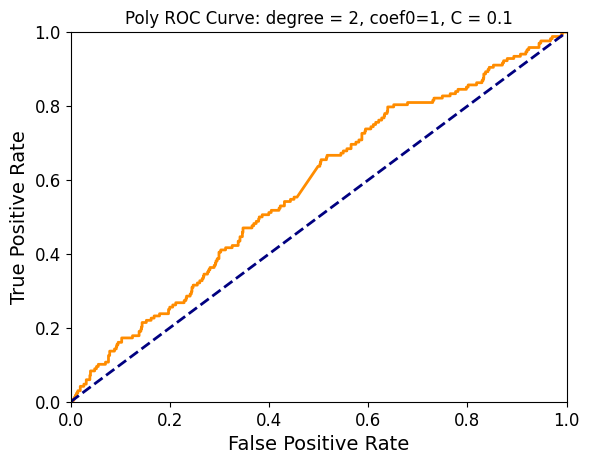

In [ ]:
c_param = 0.1
deg = 2
c0 = 1

poly_kernel_svm_clf_flip = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled, y_train_resampled)
y_prob = np.ones(len((X_test)[:, 1])) - poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

# 7. New Data Pipeline

## In this section, I make a new data pipeline to use for the SVM to use and try previous methods with the new pipeline. This pipeline makes 3x3 boxes around points with depth 30 (layers 0 through 30), as opposed to the original 7x7 with depth 5. I do not find a good model.

## 7.1 Load In Data and Balance w/ ADASYN

In [11]:
# Parameters
images = '123'
total_samples, train_split, test_split = 5000, 0.8, 0.2  # Approximately 5000 samples, 80% of which are training and 20% are testing
buffer, z_start, z_end = 1, 0, 30  # 2*buffer+1 = 7, z_end-z_start = 5 -> input shape is 7x7x5
cached_rows, batch_size = 1000, 128  # Increasing cached_rows and/or batch_size increases memory usage and decreases load time, but should have no effect on the data itself

def load_xy_data(mask):
    seq = VesuviusTrainingSequence(images=images, input_buffer=buffer, z_start=z_start, z_end=z_end, cached_rows=cached_rows, batch_size=batch_size, mask_suffix=mask, transforms=None, seed=42)
    batches = [batch for batch in tqdm(seq, total=len(seq), desc=f'Loading {mask} data')]
    X_data, y_data = np.concatenate([x for x, y in batches]), np.concatenate([y for x, y in batches])
    return X_data.reshape(len(X_data), -1), y_data.flatten()

# Split into train/test
percent_data_used = total_samples / sum(IMAGE_MASK_COUNTS[image] for image in images)
split_mask(images, [train_split*percent_data_used, test_split*percent_data_used], ['train', 'test'], seed=42)

# Load data
X_train2, y_train2 = load_xy_data('train')
X_test2, y_test2 = load_xy_data('test')

print('\nTrain data shape:', X_train2.shape, y_train2.shape)
print('\nTest data shape:', X_test2.shape, y_test2.shape)

Loading test data: 100%|██████████| 32/32 [25:56<00:00, 48.64s/it]


Train data shape: (4039, 270) (4039,)

Test data shape: (994, 270) (994,)


In [18]:
from collections import Counter
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN

# Print the class distribution before resampling
print("Before resampling:", Counter(y_train))

# Resample the training set using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled2, y_train_resampled2 = adasyn.fit_resample(X_train2, y_train2)

# Print the class distribution after resampling
print("After resampling:", Counter(y_train_resampled2))

Before resampling: Counter({0.0: 3379, 1.0: 660})
After resampling: Counter({1.0: 3466, 0.0: 3379})


## 7.2 Original Data

### I carry out a few models with no transformations on the data

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  1 167]]
Threshold: 0.2
Confusion matrix:
[[  2 824]
 [  2 166]]
Threshold: 0.25
Confusion matrix:
[[  6 820]
 [  3 165]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 16 810]
 [  5 163]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 48 778]
 [ 15 153]]
Threshold: 0.4
Confusion matrix:
[[120 706]
 [ 31 137]]
Threshold: 0.45
Confusion matrix:
[[259 567]
 [ 65 103]]
Threshold: 0.5
Confusion matrix:
[[437 389]
 [ 95  73]]
Threshold: 0.55
Confusion matrix:
[[610 216]
 [124  44]]
Threshold: 0.6000000000000001
Confusion matrix:
[[730  96]
 [146  22]]
Threshold: 0.65
Confusion matrix:
[[781  45]
 [161   7]]
Threshold: 0.7000000000000001
Confusion matrix:
[[810  16]
 [166   2]]
Threshold: 0.75
Confusion matrix:
[[822   4]
 [168   0]]
Threshold: 0.8
Confu

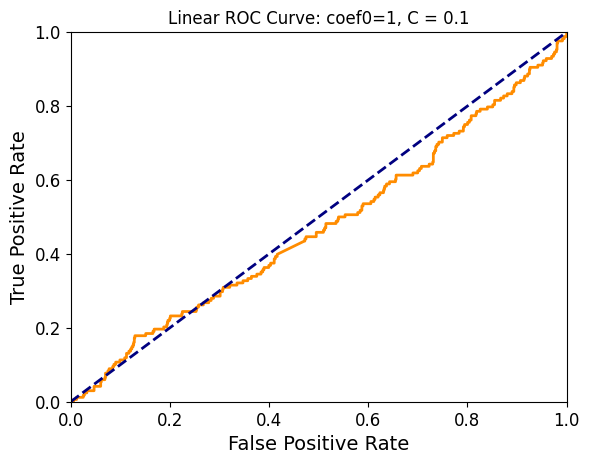

In [19]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(X_train_resampled2, y_train_resampled2)
y_prob = lin_kernel_svm_clf.predict_proba(X_test2)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 17 809]
 [  4 164]]
Threshold: 0.1
Confusion matrix:
[[ 47 779]
 [ 10 158]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 63 763]
 [ 13 155]]
Threshold: 0.2
Confusion matrix:
[[103 723]
 [ 19 149]]
Threshold: 0.25
Confusion matrix:
[[133 693]
 [ 21 147]]
Threshold: 0.30000000000000004
Confusion matrix:
[[171 655]
 [ 32 136]]
Threshold: 0.35000000000000003
Confusion matrix:
[[220 606]
 [ 40 128]]
Threshold: 0.4
Confusion matrix:
[[285 541]
 [ 64 104]]
Threshold: 0.45
Confusion matrix:
[[360 466]
 [ 84  84]]
Threshold: 0.5
Confusion matrix:
[[442 384]
 [ 98  70]]
Threshold: 0.55
Confusion matrix:
[[545 281]
 [120  48]]
Threshold: 0.6000000000000001
Confusion matrix:
[[649 177]
 [143  25]]
Threshold: 0.65
Confusion matrix:
[[742  84]
 [150  18]]
Threshold: 0.7000000000000001
Confusion matrix:
[[779  47]
 [156  12]]
Threshold: 0.75
Confusion matrix:
[[808  18]
 [161   7]]
Threshold: 0.8
Confu

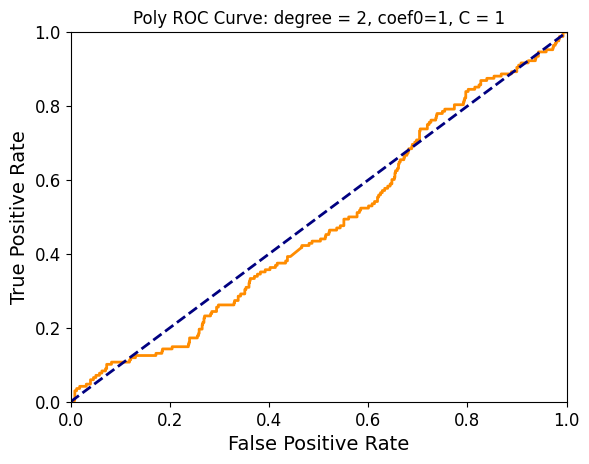

In [20]:
c_param = 1
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled2, y_train_resampled2)
y_prob = poly_kernel_svm_clf.predict_proba(X_test2)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[213 613]
 [ 44 124]]
Threshold: 0.1
Confusion matrix:
[[295 531]
 [ 60 108]]
Threshold: 0.15000000000000002
Confusion matrix:
[[373 453]
 [ 76  92]]
Threshold: 0.2
Confusion matrix:
[[419 407]
 [ 88  80]]
Threshold: 0.25
Confusion matrix:
[[477 349]
 [ 96  72]]
Threshold: 0.30000000000000004
Confusion matrix:
[[521 305]
 [111  57]]
Threshold: 0.35000000000000003
Confusion matrix:
[[564 262]
 [120  48]]
Threshold: 0.4
Confusion matrix:
[[596 230]
 [124  44]]
Threshold: 0.45
Confusion matrix:
[[640 186]
 [128  40]]
Threshold: 0.5
Confusion matrix:
[[668 158]
 [131  37]]
Threshold: 0.55
Confusion matrix:
[[703 123]
 [134  34]]
Threshold: 0.6000000000000001
Confusion matrix:
[[724 102]
 [141  27]]
Threshold: 0.65
Confusion matrix:
[[741  85]
 [150  18]]
Threshold: 0.7000000000000001
Confusion matrix:
[[751  75]
 [154  14]]
Threshold: 0.75
Confusion matrix:
[[764  62]
 [154  14]]
Threshold: 0.8
Confu

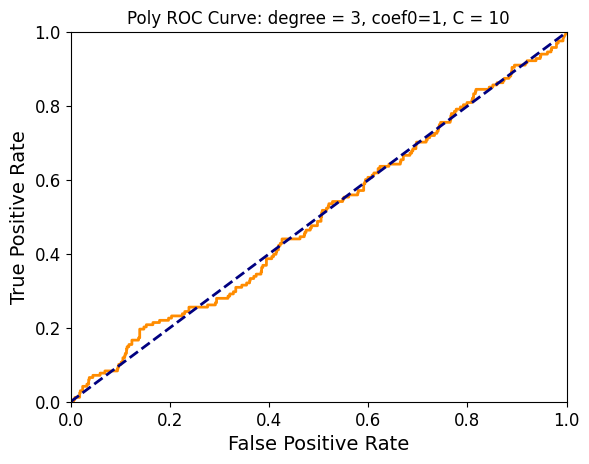

In [21]:
c_param = 10
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(X_train_resampled2, y_train_resampled2)
y_prob = poly_kernel_svm_clf.predict_proba(X_test2)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 16 810]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 41 785]
 [  1 167]]
Threshold: 0.4
Confusion matrix:
[[ 99 727]
 [  9 159]]
Threshold: 0.45
Confusion matrix:
[[238 588]
 [ 41 127]]
Threshold: 0.5
Confusion matrix:
[[380 446]
 [ 77  91]]
Threshold: 0.55
Confusion matrix:
[[585 241]
 [118  50]]
Threshold: 0.6000000000000001
Confusion matrix:
[[728  98]
 [150  18]]
Threshold: 0.65
Confusion matrix:
[[810  16]
 [167   1]]
Threshold: 0.7000000000000001
Confusion matrix:
[[822   4]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

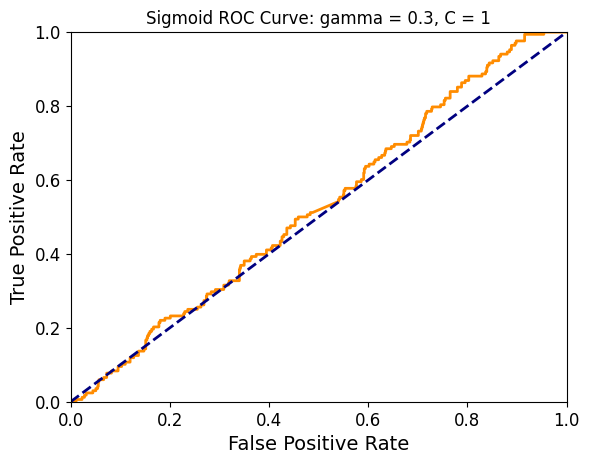

In [22]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled2, y_train_resampled2)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test2)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[ 35 791]
 [  4 164]]
Threshold: 0.45
Confusion matrix:
[[156 670]
 [ 28 140]]
Threshold: 0.5
Confusion matrix:
[[348 478]
 [ 70  98]]
Threshold: 0.55
Confusion matrix:
[[631 195]
 [136  32]]
Threshold: 0.6000000000000001
Confusion matrix:
[[778  48]
 [161   7]]
Threshold: 0.65
Confusion matrix:
[[823   3]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

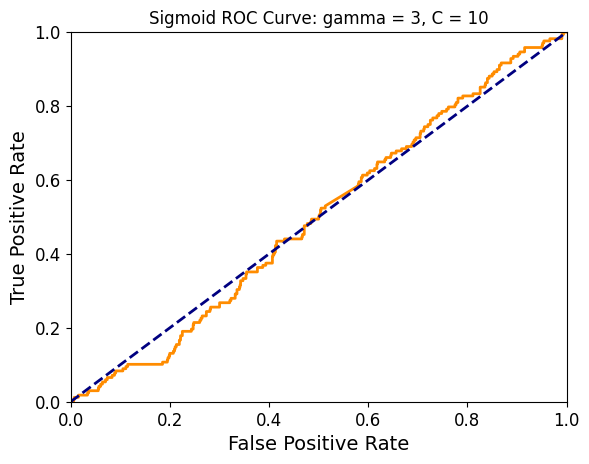

In [23]:
g_param = 3
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(X_train_resampled2, y_train_resampled2)
y_prob = sgm_kernel_svm_clf.predict_proba(X_test2)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

## 7.3 Nonlinear Transformation

### I carry out a few models with transformations on the data

In [55]:
train2_sin = np.sin(np.pi * X_train_resampled2)
test2_sin = np.sin(np.pi * X_test2)

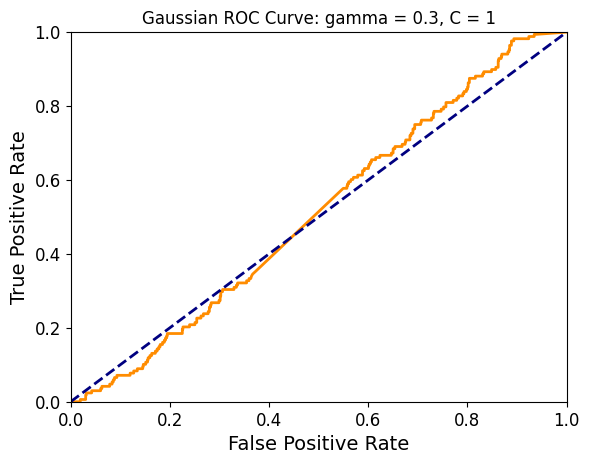

In [57]:
g_param = 0.3
c_param = 1

rbf_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", gamma=g_param, C=c_param, probability=True)
)
rbf_kernel_svm_clf.fit(train2_sin, y_train_resampled2)
y_prob = rbf_kernel_svm_clf.predict_proba(test2_sin)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Gaussian ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

In [31]:
train2_poly10 = (X_train_resampled2)**10
test2_poly10 = (X_test2)**10

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[ 10 816]
 [  2 166]]
Threshold: 0.1
Confusion matrix:
[[ 14 812]
 [  3 165]]
Threshold: 0.15000000000000002
Confusion matrix:
[[ 21 805]
 [  4 164]]
Threshold: 0.2
Confusion matrix:
[[ 29 797]
 [  6 162]]
Threshold: 0.25
Confusion matrix:
[[ 35 791]
 [  6 162]]
Threshold: 0.30000000000000004
Confusion matrix:
[[ 41 785]
 [  6 162]]
Threshold: 0.35000000000000003
Confusion matrix:
[[ 50 776]
 [  9 159]]
Threshold: 0.4
Confusion matrix:
[[ 75 751]
 [ 13 155]]
Threshold: 0.45
Confusion matrix:
[[118 708]
 [ 22 146]]
Threshold: 0.5
Confusion matrix:
[[234 592]
 [ 46 122]]
Threshold: 0.55
Confusion matrix:
[[802  24]
 [165   3]]
Threshold: 0.6000000000000001
Confusion matrix:
[[818   8]
 [167   1]]
Threshold: 0.65
Confusion matrix:
[[818   8]
 [167   1]]
Threshold: 0.7000000000000001
Confusion matrix:
[[822   4]
 [167   1]]
Threshold: 0.75
Confusion matrix:
[[823   3]
 [168   0]]
Threshold: 0.8
Confu

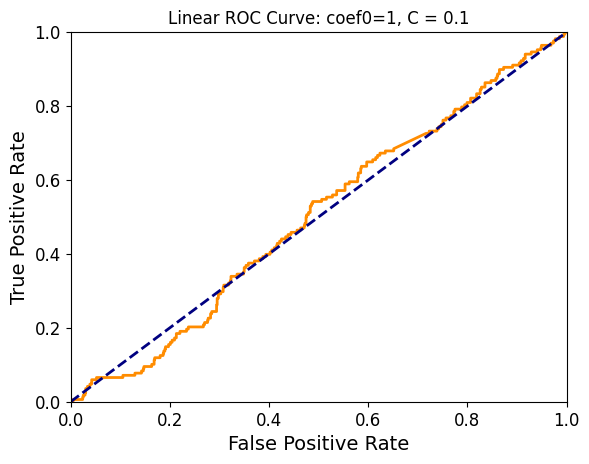

In [32]:
c_param = 0.1

lin_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="linear", coef0=1, C=c_param, probability=True)
)
lin_kernel_svm_clf.fit(train2_poly10, y_train_resampled2)
y_prob = lin_kernel_svm_clf.predict_proba(test2_poly10)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Linear ROC Curve: coef0=1, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.55
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[825   1]
 [168   0]]
Threshold: 0.8
Confu

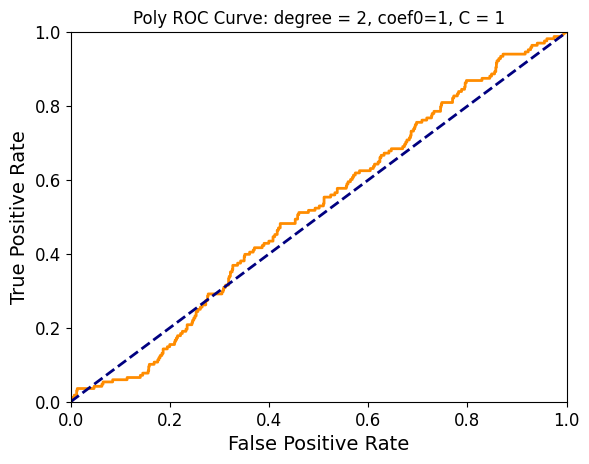

In [33]:
c_param = 1
deg = 2
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train2_poly10, y_train_resampled2)
y_prob = poly_kernel_svm_clf.predict_proba(test2_poly10)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  1 825]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  1 825]
 [  1 167]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  2 824]
 [  1 167]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  2 824]
 [  1 167]]
Threshold: 0.4
Confusion matrix:
[[  2 824]
 [  1 167]]
Threshold: 0.45
Confusion matrix:
[[  4 822]
 [  2 166]]
Threshold: 0.5
Confusion matrix:
[[  7 819]
 [  4 164]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

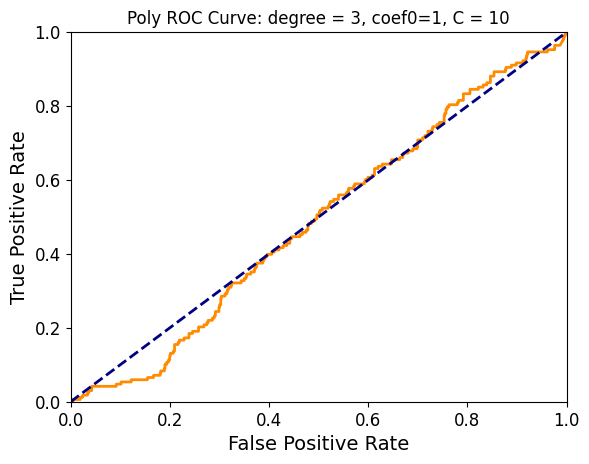

In [34]:
c_param = 10
deg = 3
c0 = 1

poly_kernel_svm_clf = make_pipeline(
  StandardScaler(),
  SVC(kernel="poly", degree=deg, coef0=c0, C=c_param, probability=True)
)
poly_kernel_svm_clf.fit(train2_poly10, y_train_resampled2)
y_prob = poly_kernel_svm_clf.predict_proba(test2_poly10)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))


# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Poly ROC Curve: degree = {deg}, coef0={c0}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  8 818]
 [  1 167]]
Threshold: 0.5
Confusion matrix:
[[163 663]
 [ 40 128]]
Threshold: 0.55
Confusion matrix:
[[787  39]
 [160   8]]
Threshold: 0.6000000000000001
Confusion matrix:
[[820   6]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

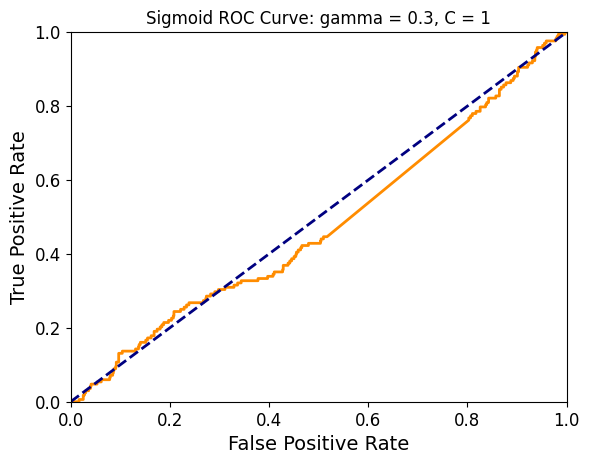

In [35]:
g_param = 0.3
c_param = 1

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train2_poly10, y_train_resampled2)
y_prob = sgm_kernel_svm_clf.predict_proba(test2_poly10)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

Threshold: 0.0
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.05
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.1
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.15000000000000002
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.2
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.25
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.30000000000000004
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.35000000000000003
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.4
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.45
Confusion matrix:
[[  0 826]
 [  0 168]]
Threshold: 0.5
Confusion matrix:
[[155 671]
 [ 26 142]]
Threshold: 0.55
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.6000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.65
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.7000000000000001
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.75
Confusion matrix:
[[826   0]
 [168   0]]
Threshold: 0.8
Confu

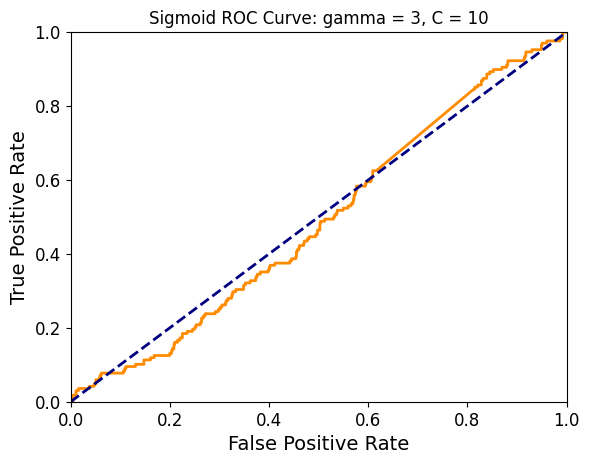

In [36]:
g_param = 3
c_param = 10

sgm_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=g_param, C=c_param, probability=True)
)
sgm_kernel_svm_clf.fit(train2_poly10, y_train_resampled2)
y_prob = sgm_kernel_svm_clf.predict_proba(test2_poly10)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test2, y_prob)


# Specify the intervals of the threshold
interval = 0.05
threshold_range = np.arange(0, 1+interval, interval)

# Generate confusion matrices for each interval of the threshold
for threshold in threshold_range:
    y_pred = y_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Threshold:', threshold)
    print('Confusion matrix:')
    print(np.array([[tn, fp], [fn, tp]]))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Sigmoid ROC Curve: gamma = {g_param}, C = {c_param}')
plt.show()

# 8. Show Prediction

## In this section, I show a prediction for where the ink is on a scroll. I use the sigmoid model because it was feasible with computation time and was comparable to other better models I achieved. As can be seen, my prediction does not result in something usable to decipher text.

In [ ]:
sgm_kernel_svm_clf_pic = make_pipeline(
    StandardScaler(),
    SVC(kernel="sigmoid", gamma=3, C=10)
)

sgm_kernel_svm_clf_pic.fit(X_train_resampled, y_train_resampled)

cm = confusion_matrix(y_test, sgm_kernel_svm_clf_pic.predict(X_test))
print(cm)
tn, fp, fn, tp = cm.ravel()
fpr, tpr = [fp/(tn+fp), tp/(tp+fn)]
distance = (tpr-fpr)*np.sqrt(1/2)
print(distance)

[[399 427]
 [ 73  95]]
0.03431379759389928


Predicting image 1: 100%|██████████| 3558/3558 [3:19:54<00:00,  3.37s/it]


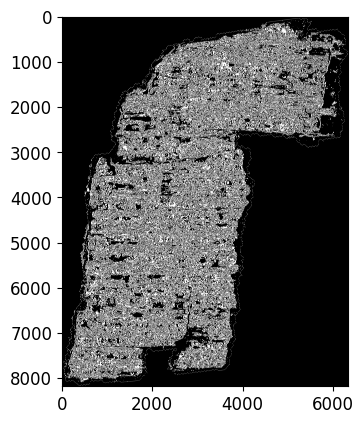

In [ ]:
show_prediction('1', sgm_kernel_svm_clf_pic, prediction_cached_rows=None, prediction_batch_size=8192)